# LendingClub data - machine learning

## Intro

The dataset used in this notebook contains customer (borrower) and loan information for accepted loans as well as for rejected loan applications over **the period ranging from 2017 to 2018 (including)**.

Based on the project requirements there are 4 ML goals (targets):
1. classify loan applications into accepted or rejected
1. predict the grade for the loan
1. predict the sub-grade for the loan
1. predict interest rate for the loan

**Note:** detailed EDA could be found in a separate notebook - '335_EDA.ipynb'. 

### Structure

- Classifying loan applications into accepted or rejected:
    - EDA was performed for the period of 2017-2018 and led to the discovery that FICO score is the main feature for classifying loan applications into accepted and rejected. 
    - However dataframe of rejected loans has the large number of missing values for FICO score in 2018 (more than 90%) and deleting all the cases with missing values would impact data distribution, therefore I have decided to use 2017 data for model training, selection and analysis, and perform final model testing on 2018 data.
    - Final (after cleaning) 2017 dataframe contains more than 4M observations, while 2018 data - more than 1M observations.
- Predicting grade, sub-grade and interest rate:
    - Only dataframe of accepted loans was used for grade, sub-grade and interest rate prediction (this information is not applicable for rejected loans). Dataframe contains more than 700K observations for the period of 2017-2018. 
    - Data was not split by year as no obvious pattern observed.
- General ML process:
    - Feature selection (if needed)
    - Preprocessing and choosing data transformers
    - Model selection (not applicable for sub-grade and interest rate)
    - Hyperparameter tuning
    - Model performance analysis including feature importance

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from functions import *

import joblib
import pickle
from collections import Counter
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    StratifiedKFold,
    cross_val_predict,
)
from sklearn.metrics import (
    roc_auc_score,
    recall_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    mean_squared_error,
    f1_score,
    average_precision_score,
    precision_score,
    r2_score,
)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
)

import optuna
from optuna.samplers import TPESampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cbt

import warnings

np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set_palette("icefire")
plt.rcParams["figure.dpi"] = 200

In [2]:
import shap

shap.initjs()

In [3]:
RANDOM = 101

***

## Accepted vs rejected

**Approach**

- Dataset of all (both accepted and rejected) loan applications for 2017 contains more than 4M observations. The sample of more than 100000 observations was taken for model selection, tuning and analysis before fitting the final model to full data for 2017.
- I chose F1-score as the main metric for model evaluation because, based on my understanding, for peer-to-peer lending platform it is equally important to correctly classify both accepted and rejected loan applications (macro f1-score is low for models that only perform well on the common classes while performing poorly on the rare classes) as:
    - Rejecting risky applicants on time prevents from loan default (occurs when a borrower fails to pay back a debt according to the initial arrangement);
    - Correctly identifying applications to be accepted provides financial gain;
- Additionally, feature importance is checked to understand what features have the greatest impact on predictions and whether they are consistent with EDA findings.

**Note:**   
Notation used in classification report and confusion matrix:  
- Class 0 - rejected loan applications
- Class 1 - accepted loan applications

In [4]:
loans = pd.read_csv("loans.csv", low_memory=False)

In [5]:
loans.isnull().sum()

amount_requested           0
date                       0
loan_purpose               0
fico_score          11346063
dti_ratio                  0
state                      0
emp_length                 0
loan_status                0
state_long                 0
dtype: int64

In [6]:
loans[loans.duplicated()].count()

amount_requested    415529
date                415529
loan_purpose        415529
fico_score           11992
dti_ratio           415529
state               415529
emp_length          415529
loan_status         415529
state_long          415529
dtype: int64

**Insights**

- EDA and online resource analysis indicate that FICO score is one of the most important factors for deciding whether applicant is eligible to get a loan (especially for peer-to-peer lending platforms as they don't gather much other information about borrower). Based on my understanding, if FICO score is missing loan application will be rejected (declined) by default (even before the data is provided to predictive algorithm) therefore I decided to drop all cases where FICO score is missing instead of replacing them with some value.
- Duplicates are also dropped to avoid adding weights to observations.

In [7]:
loans = loans.dropna()
loans = loans.drop(
    loans[loans.duplicated() == True].index,
)
loans = loans.drop(columns=["state_long"])

In [8]:
loans.head()

amount_requested        date        loan_purpose  fico_score  dti_ratio  \
0            5000.0  2018-03-01               other       667.0      21.80   
1           15000.0  2018-03-01  debt_consolidation       702.0      18.29   
2           25000.0  2018-03-01  debt_consolidation       667.0      12.89   
3            3000.0  2018-03-01      major_purchase       762.0       0.58   
4           17000.0  2018-03-01  debt_consolidation       672.0      15.65   

  state emp_length  loan_status  
0    OK    8 years            1  
1    FL    2 years            1  
2    AL  10+ years            1  
3    WA    9 years            1  
4    FL  10+ years            1

**Data splitting by year**

As mentioned in the Intro part, I have decided to use 2017 data for model training, selection and analysis, and perform final model testing on 2018 data.

In [9]:
loans["date"] = pd.to_datetime(loans["date"])
loans_2018 = loans[loans["date"].dt.year == 2018]
loans_2017 = loans[loans["date"].dt.year == 2017]

In [10]:
loans_2017.shape

(4100052, 8)

In [11]:
loans_2018.shape

(1051250, 8)

In [12]:
loans_2017["loan_status"].value_counts(normalize=True).round(2)

0    0.9
1    0.1
Name: loan_status, dtype: float64

In [13]:
loans_2018["loan_status"].value_counts(normalize=True).round(2)

0    0.59
1    0.41
Name: loan_status, dtype: float64

### Pre-processing and feature engineering

In [14]:
loans_sample = loans_2017.groupby("loan_status", group_keys=False).apply(
    lambda x: x.sample(frac=0.04)
)
loans_sample.shape

(164002, 8)

In [15]:
y = loans_sample["loan_status"]
X = loans_sample.drop(["loan_status"], axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM
)

In [17]:
month = FunctionTransformer(get_month, check_inverse=False)
cyclic_month = FunctionTransformer(get_month_cyclic, check_inverse=False)

In [18]:
feat_extractor = Pipeline(
    steps=[
        ("month", month),
        ("cyclic_month", cyclic_month),
        ("dti_by_state", MeanByState(column="dti_ratio")),
        ("fico_by_state", MeanByState(column="fico_score")),
    ]
)

In [19]:
numeric_features = [
    "amount_requested",
    "fico_score",
    "dti_ratio",
    "mean_dti_ratio_by_state",
    "mean_fico_score_by_state",
    "month_sin",
    "month_cos",
]
categorical_features = ["loan_purpose", "state", "emp_length"]

In [20]:
categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))]
)

numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

preprocessor_app_status = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_features),
        ("numeric", numeric_transformer, numeric_features),
    ],
    remainder="passthrough",
)

In [21]:
pipe_loan_status = Pipeline(
    steps=[
        ("feat_extractor", feat_extractor),
        ("preprocessor", preprocessor_app_status),
    ]
)

### Model selection

To get a sense of how chosen classifiers perform on unseen data, I use cross validation to partition the data into many training and test samples and measure out-of-sample key metrics: f1-score, precision and recall.

In [22]:
X_train_tr = pipe_loan_status.fit_transform(X_train)

In [23]:
classifiers_app_status = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("LinearSVC", LinearSVC()),
    ("Random Forest", RandomForestClassifier()),
    (
        "XGBoost",
        xgb.XGBClassifier(
            objective="reg:logistic",
            use_label_encoder=False,
        ),
    ),
    (
        "CatBoost",
        cbt.CatBoostClassifier(
            iterations=1000,
            loss_function="Logloss",
            verbose=0,
        ),
    ),
    ("LightGBM", lgb.LGBMClassifier(objective="binary", verbosity=-1)),
]

In [24]:
cls_comparison = compare_classifiers(classifiers_app_status, X_train_tr, y_train)
cls_comparison = cls_comparison.set_index("Classifier")

cls_comparison.style.format("{0:,.3f}").background_gradient(cmap='Blues', subset=['F1-score'])

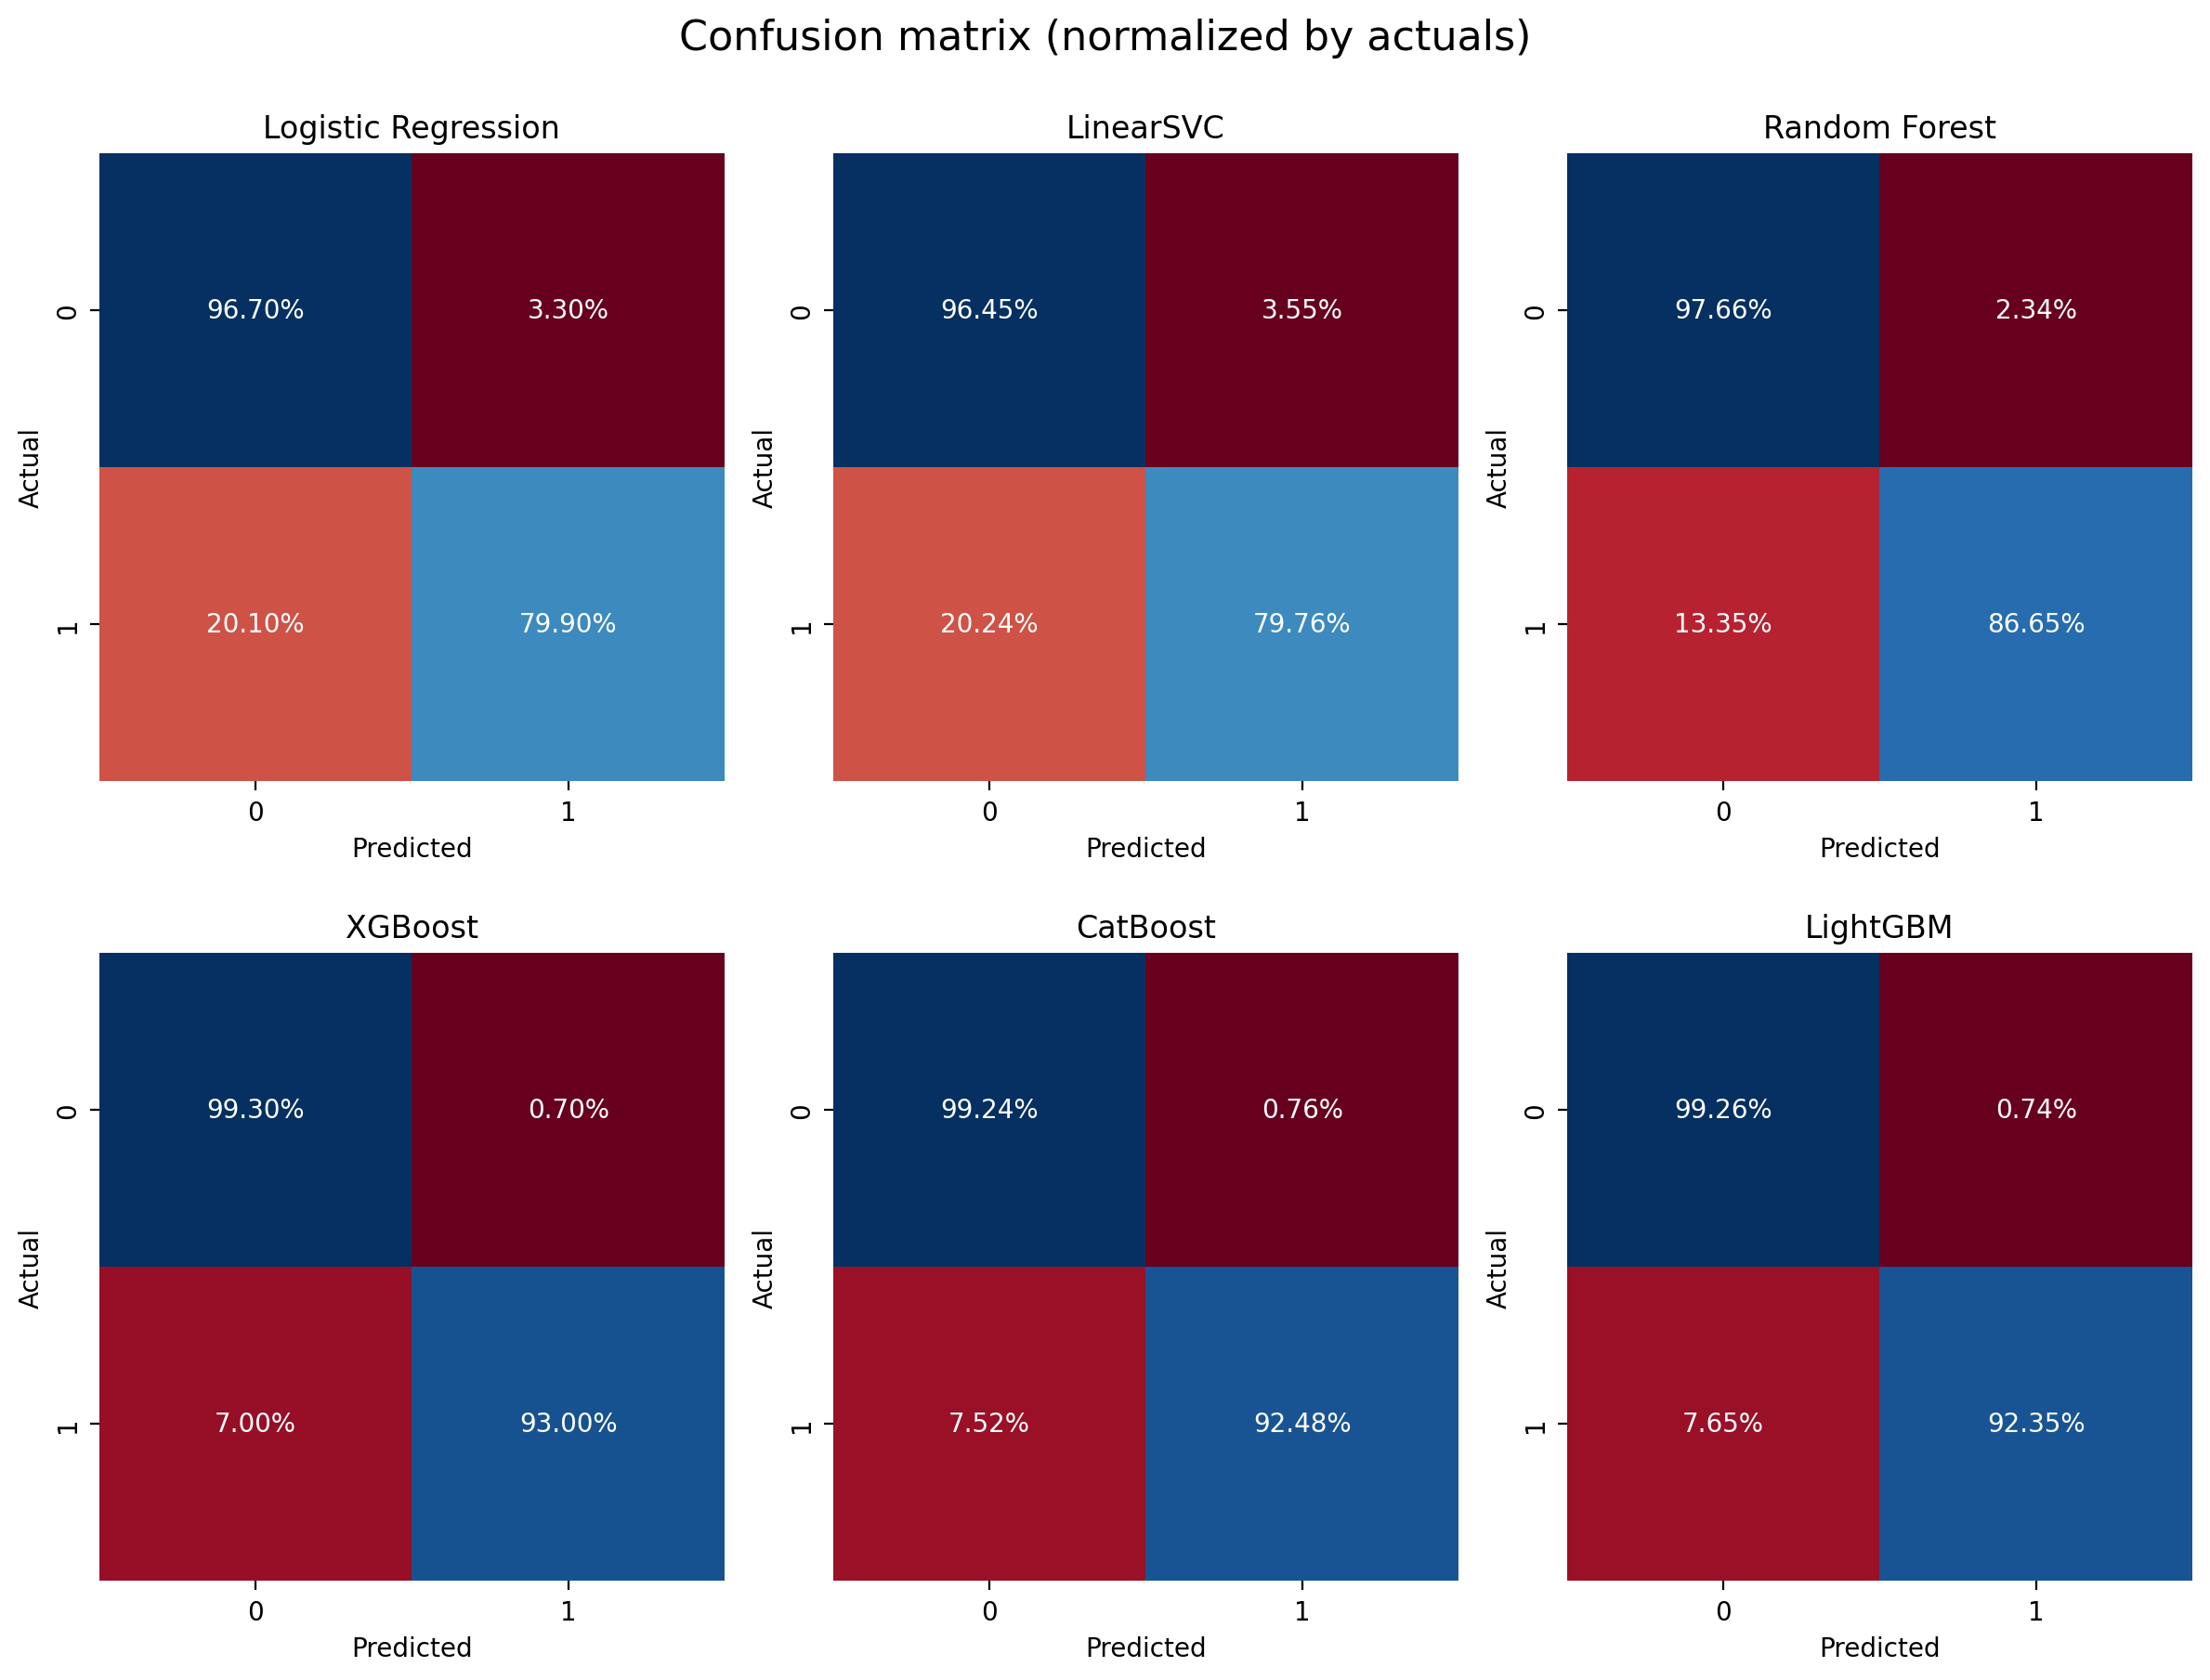

In [25]:
plot_cm_comparison(classifiers_app_status, X_train_tr, y_train)

**Insights**

- Even without hyperparameter tuning classifiers show really high prediction results - F1-score for all ensemble classifiers are above 90%.
- The highest F1-score is obtained by XGBoost and the lowest fit-time - by LightGBM, therefore these classifiers are chosen for HP tuning.

### XGBoost

#### HP tuning

In [26]:
sampler = TPESampler(seed=RANDOM)
study_xgb = optuna.create_study(direction="maximize", sampler=sampler)
study_xgb.optimize(
    lambda trial: objective_xgb(trial, X_train, y_train, pipe_loan_status),
    n_trials=10,
    show_progress_bar=True,
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
print("Best F1-score on validation set:", str(round(study_xgb.best_value, 3)))

Best F1-score on validation set: 0.965


In [28]:
xgb_hp = study_xgb.best_params

xgb_pipe_status = Pipeline(
    steps=[
        ("feat_extractor", feat_extractor),
        ("preprocessor", preprocessor_app_status),
        (
            "classifier",
            xgb.XGBClassifier(
                objective="reg:logistic",
                use_label_encoder=False,
                **xgb_hp,
                random_state=RANDOM,
            ),
        ),
    ]
).fit(X_train, y_train)

#### Model evaluation

In [29]:
xgb_pred_status = xgb_pipe_status.predict(X_test)
xgb_proba_status = xgb_pipe_status.predict_proba(X_test)

In [30]:
print(
    "\033[1m" + "Classification report for test set with XGBoost:\n\n" + "\033[0m",
    classification_report(
        y_test,
        xgb_pred_status,
    ),
)

Classification report for test set with XGBoost:

               precision    recall  f1-score   support

           0       0.99      0.99      0.99     36990
           1       0.94      0.93      0.94      4011

    accuracy                           0.99     41001
   macro avg       0.97      0.96      0.96     41001
weighted avg       0.99      0.99      0.99     41001



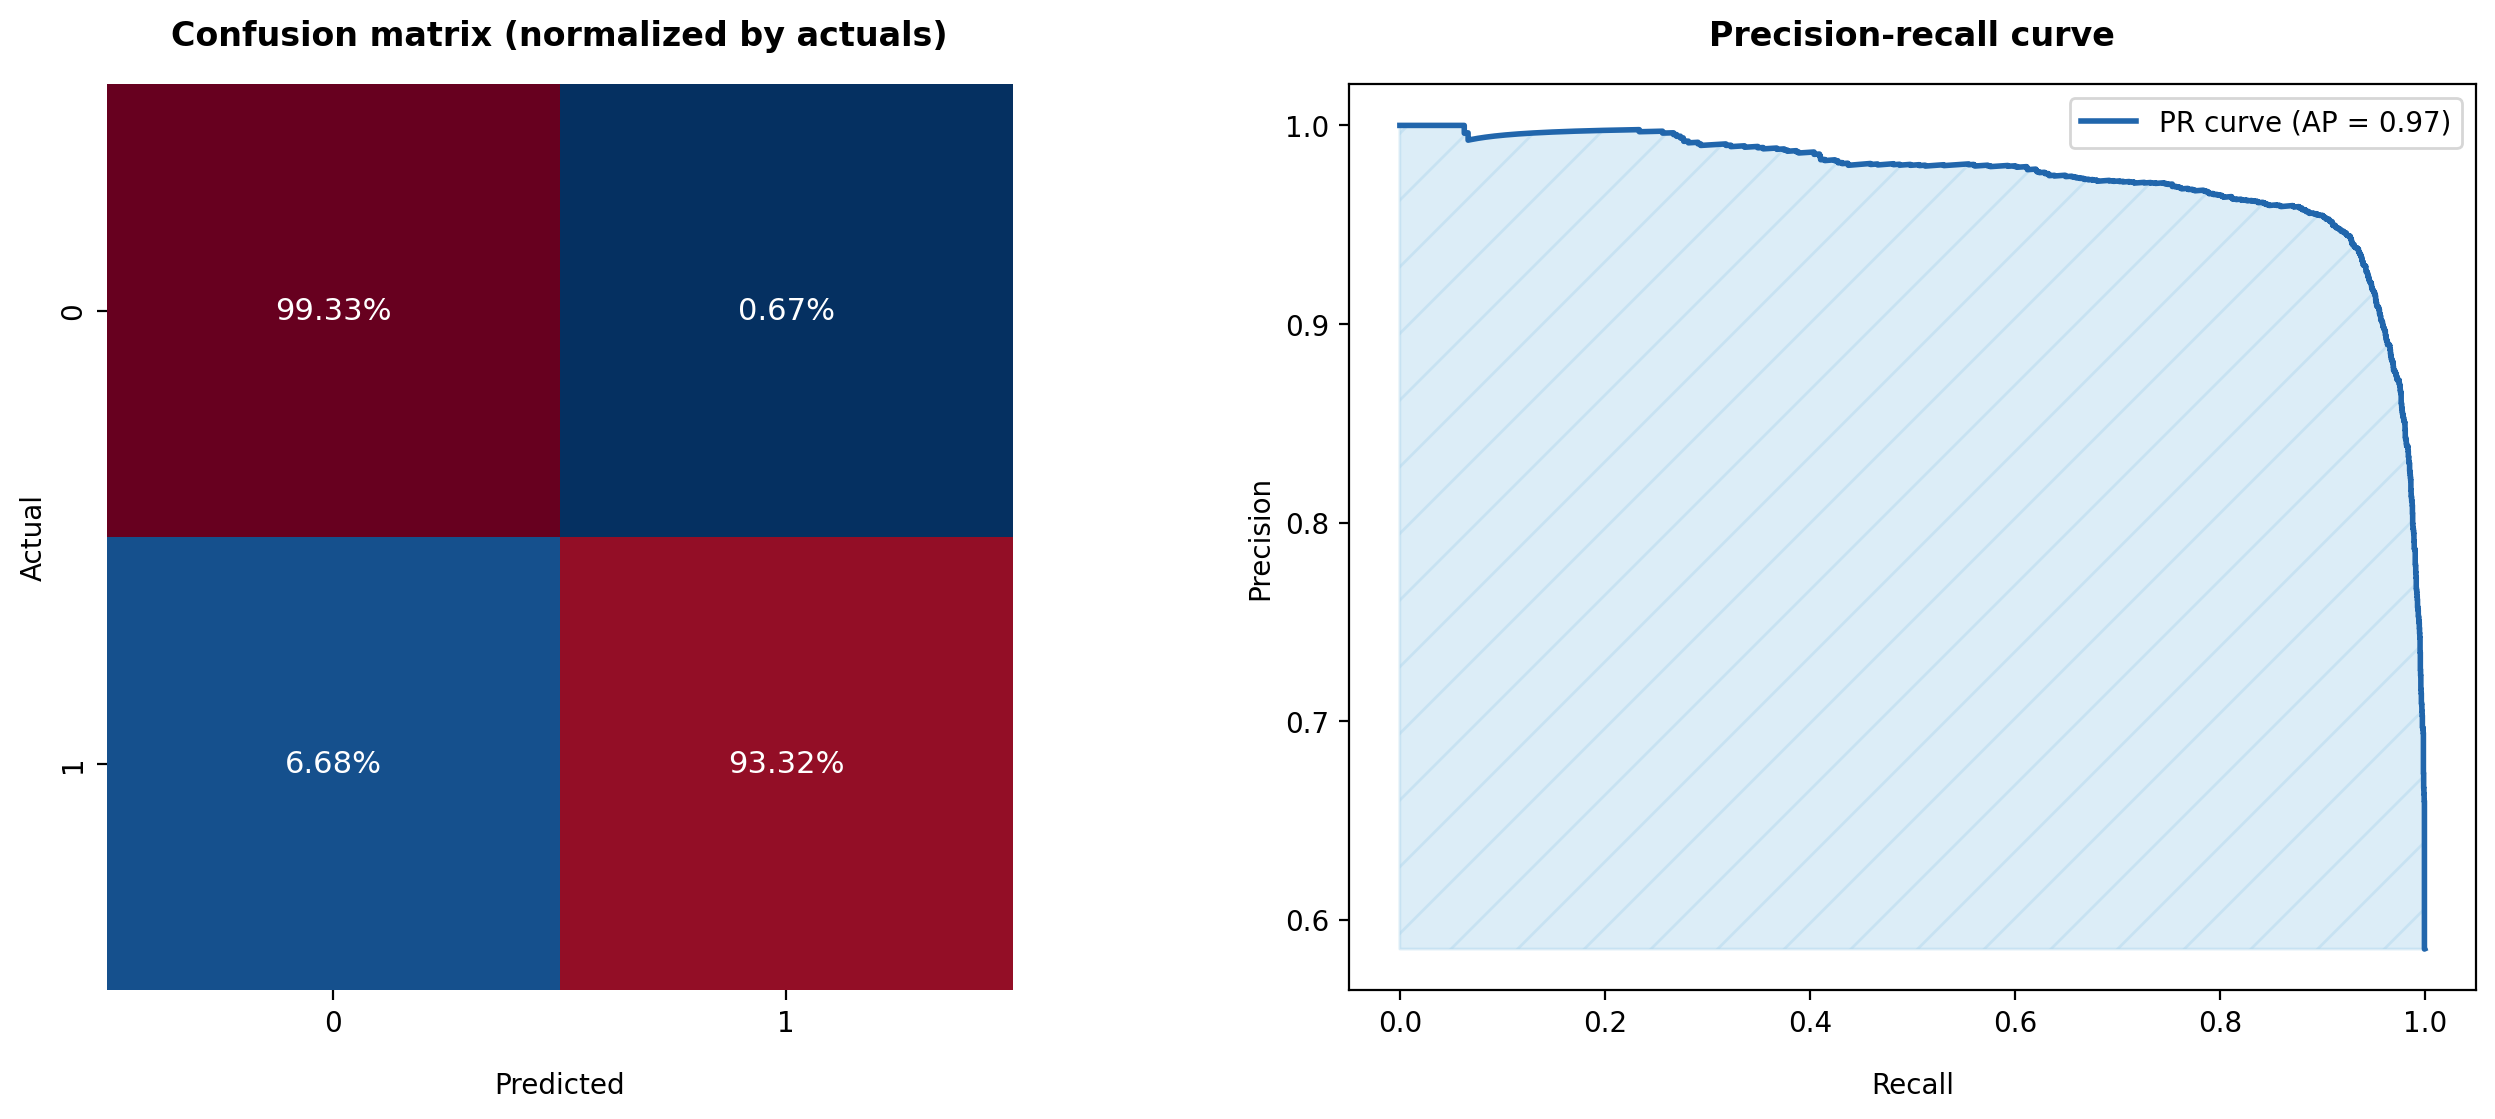

In [31]:
create_cm_pr(y_test, xgb_pred_status, xgb_proba_status)

**Insigths**

- Hyperparameter tuning provides a slight improvement comparing with baseline XGBoost. 
- XGBoost classifier provides great results on predicting both classes, especially whether application is going to be rejected - true negatives. True positives percentage is ~93% which is really good taking into account that classes are imbalanced.
- ROC curve may provide a misleading view of the classifier performance for imbalanced data, therefore Precision-Recall curve was chosen instead - it summarizes the curve with a range of threshold values as a single score and reflects the minority class in more accurate way. In this case, PR AUC represents a very high skill of XGBoost to maintain a good balance between precision and recall for class 1.

#### Feature importance

In [32]:
feature_names = list(xgb_pipe_status[1].transformers_[0][1].get_feature_names_out())

In [33]:
feature_names.extend(numeric_features)

In [34]:
X_test_tr = xgb_pipe_status[:-1].transform(X_test)
explainer = shap.TreeExplainer(xgb_pipe_status[-1])
shap_values = explainer.shap_values(X_test_tr)

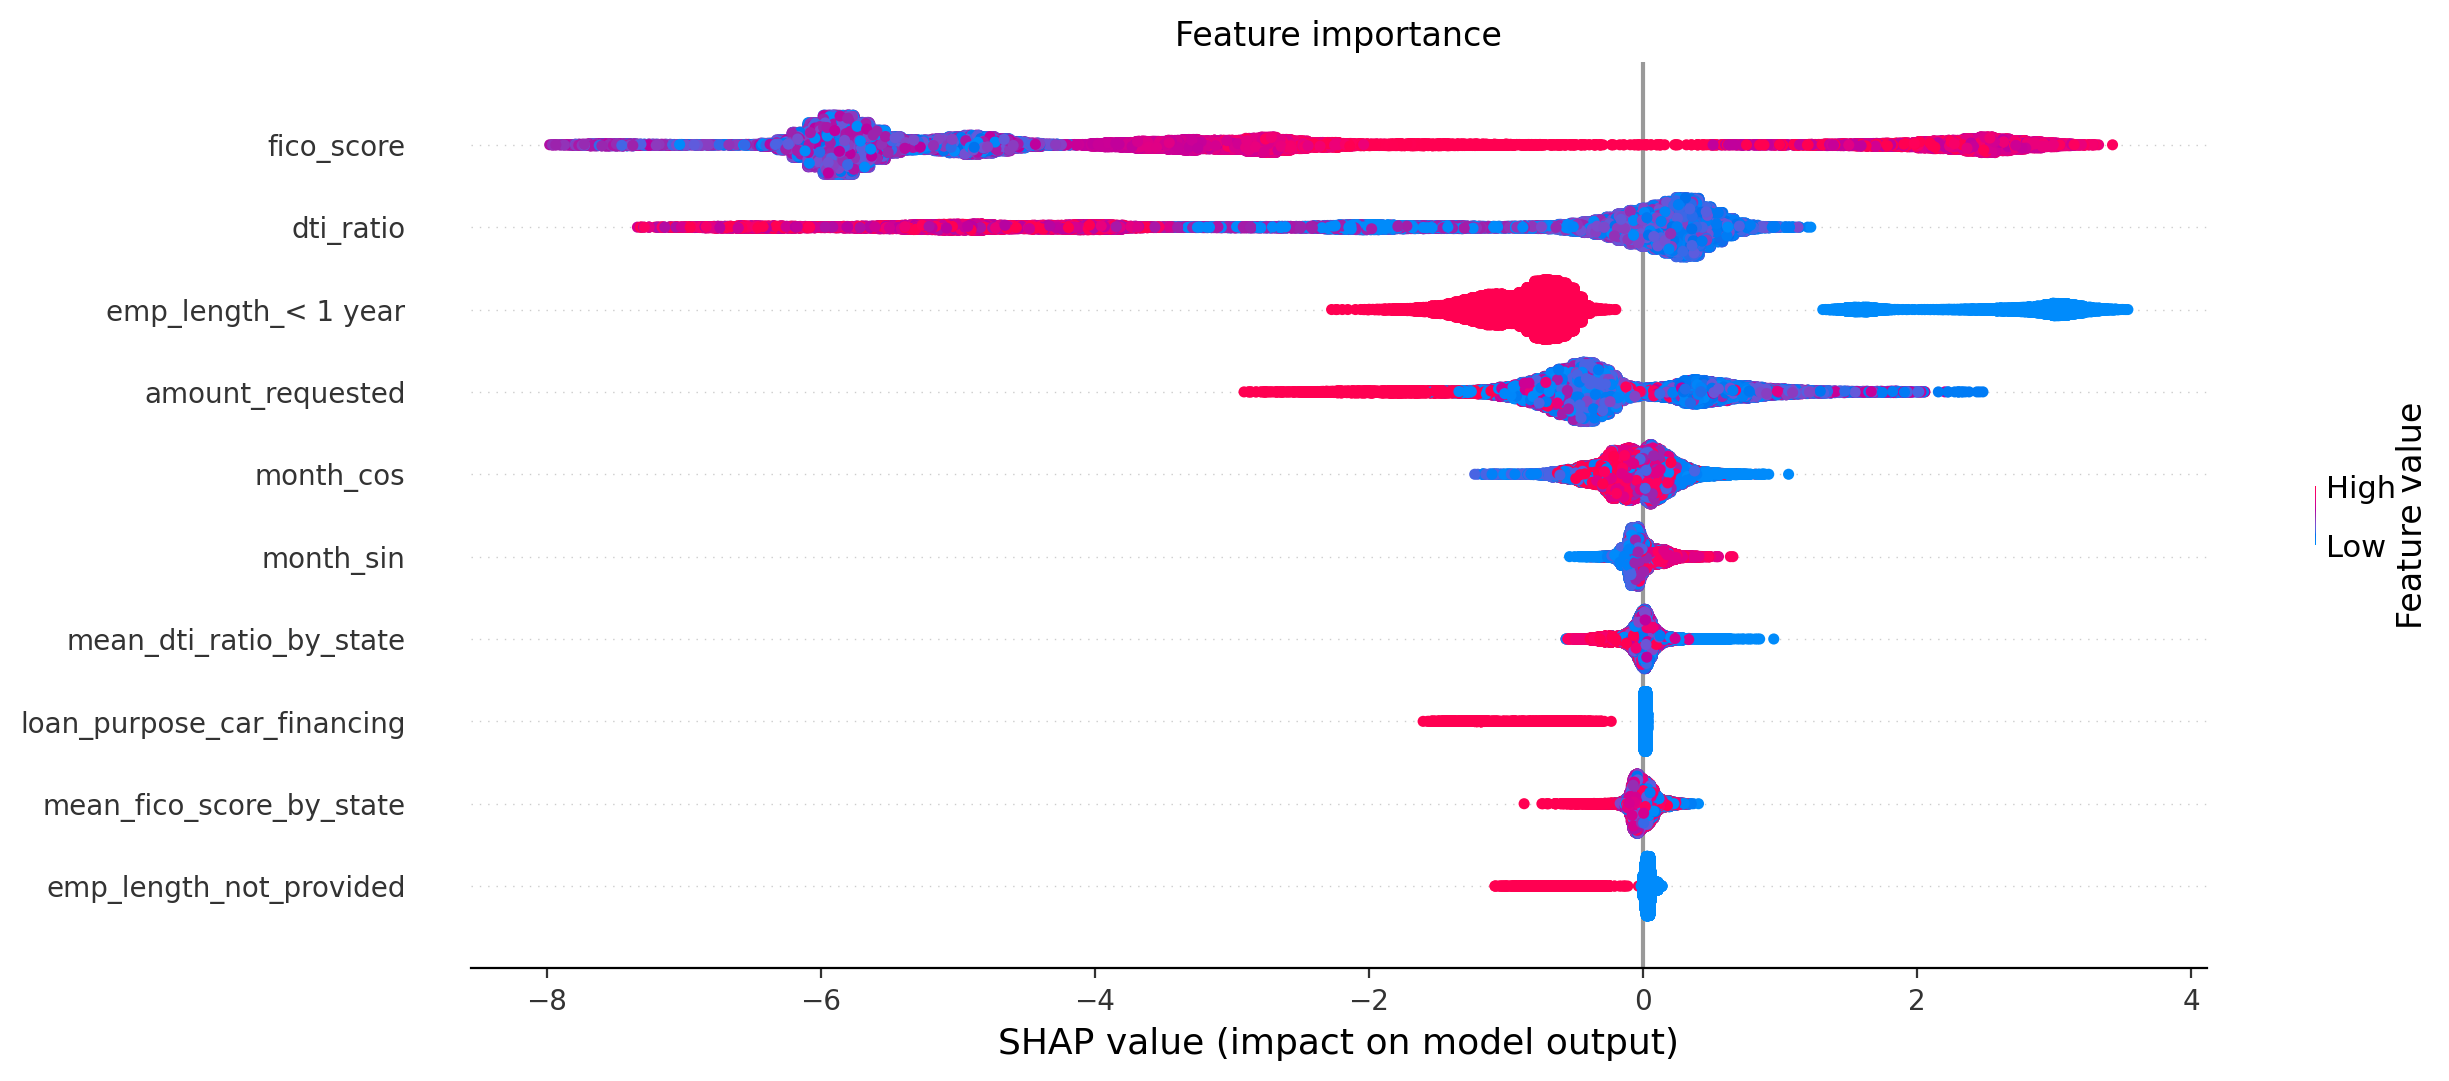

In [35]:
shap.summary_plot(
    shap_values,
    X_test_tr,
    feature_names=feature_names,
    max_display=10,
    show=False,
)

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches(14, 6)
ax.set_title("Feature importance", fontdict={"size": 12})
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=8)

**Insights**

Top most important features picked out by XGBoost coincide with EDA findings: 
- `fico_score`
- `dti_ratio`
- `emp_length_<1 year`
- `amount_requested` have the highest impact on classifying loan applications into accepted or rejected. 

#### Missclassified positive instances

In [36]:
misclassied_pos_xgboost = X_test[(y_test == 1) & (xgb_pred_status == 0)]

misclassied_pos_xgboost.shape

(268, 7)

In [37]:
misclassied_pos_xgboost.sample(10)

amount_requested       date             loan_purpose  fico_score  \
733019            7200.0 2017-12-01         medical_expenses       737.0   
714992            7000.0 2017-01-01         home_improvement       717.0   
379751            9000.0 2017-05-01           major_purchase       672.0   
318329           12000.0 2017-06-01  credit_card_refinancing       732.0   
672008            9500.0 2017-02-01       debt_consolidation       682.0   
129007           35000.0 2017-09-01           major_purchase       777.0   
672182           18900.0 2017-03-01       debt_consolidation       677.0   
102230           12000.0 2017-09-01       debt_consolidation       662.0   
386461           15000.0 2017-05-01       debt_consolidation       712.0   
367884           12000.0 2017-05-01       debt_consolidation       717.0   

        dti_ratio state emp_length  
733019       3.15    CA   < 1 year  
714992       5.54    OH   < 1 year  
379751       9.73    GA   < 1 year  
318329      29.25    MD   < 1 year  
672008      11.04    NE   < 1 year  
129007       1.20    OH    5 years  
672182      24.31    GA   < 1 year  
102230       6.99    PA   < 1 year  
386461      18.65    CA   < 1 year  
367884       5.15    IL   < 1 year

**Example of feature importance for one observation**

In [39]:
data_to_predict = X_test.loc[733019].to_frame().T

data_to_predict

amount_requested       date      loan_purpose fico_score dti_ratio  \
733019           7200.0 2017-12-01  medical_expenses      737.0      3.15   

       state emp_length  
733019    CA   < 1 year

In [40]:
ind = X_test.index.get_loc(X_test.loc[733019].name)

shap.force_plot(
    explainer.expected_value,
    shap_values[ind, :],
    pd.DataFrame(X_test_tr, columns=feature_names).iloc[ind, :],
    feature_names=feature_names,
    link="logit",
)

**Insights**

- Even though XGBoost metrics are really good, it still missclassifies ~200 accepted loans as rejected as a result of imbalanced data.
- The pattern among missclassified instances is clear: almost all of them have employment length less than one year which is the dominant feature for rejected loan applications. This could be clearly observed analyzing the impact and weight of each feature for one particular example.

In [41]:
acc_rej_pred_eval = pd.DataFrame(
    columns=["Model", "Roc-auc", "F1-score", "Precision", "Recall"]
)

acc_rej_pred_eval = append_cls_metrics(
    acc_rej_pred_eval,
    y_test,
    xgb_pred_status,
    xgb_proba_status,
    "XGBoost",
)

### LightGBM

#### HP tuning

In [42]:
sampler = TPESampler(seed=RANDOM)
study_lgbm = optuna.create_study(direction="maximize", sampler=sampler)
study_lgbm.optimize(
    lambda trial: objective_lgbm(trial, X_train, y_train, pipe_loan_status),
    n_trials=10,
    show_progress_bar=True,
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [43]:
print("Best F1-score on validation set:", str(round(study_lgbm.best_value, 3)))

Best F1-score on validation set: 0.962


In [44]:
lgbm_hp = study_lgbm.best_params

lgbm_pipe_status = Pipeline(
    steps=[
        ("feat_extractor", feat_extractor),
        ("preprocessor", preprocessor_app_status),
        (
            "classifier",
            lgb.LGBMClassifier(
                objective="binary",
                verbosity=-1,
                **lgbm_hp,
                random_state=RANDOM,
            ),
        ),
    ]
).fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


#### Model evaluation

In [45]:
lgbm_pred_status = lgbm_pipe_status.predict(X_test)
lgbm_proba_status = lgbm_pipe_status.predict_proba(X_test)

In [46]:
print(
    "\033[1m" + "Classification report for test set by LightGBM:\n\n" + "\033[0m",
    classification_report(
        y_test,
        lgbm_pred_status,
    ),
)

Classification report for test set by LightGBM:

               precision    recall  f1-score   support

           0       0.99      0.98      0.98     36990
           1       0.82      0.91      0.86      4011

    accuracy                           0.97     41001
   macro avg       0.90      0.94      0.92     41001
weighted avg       0.97      0.97      0.97     41001



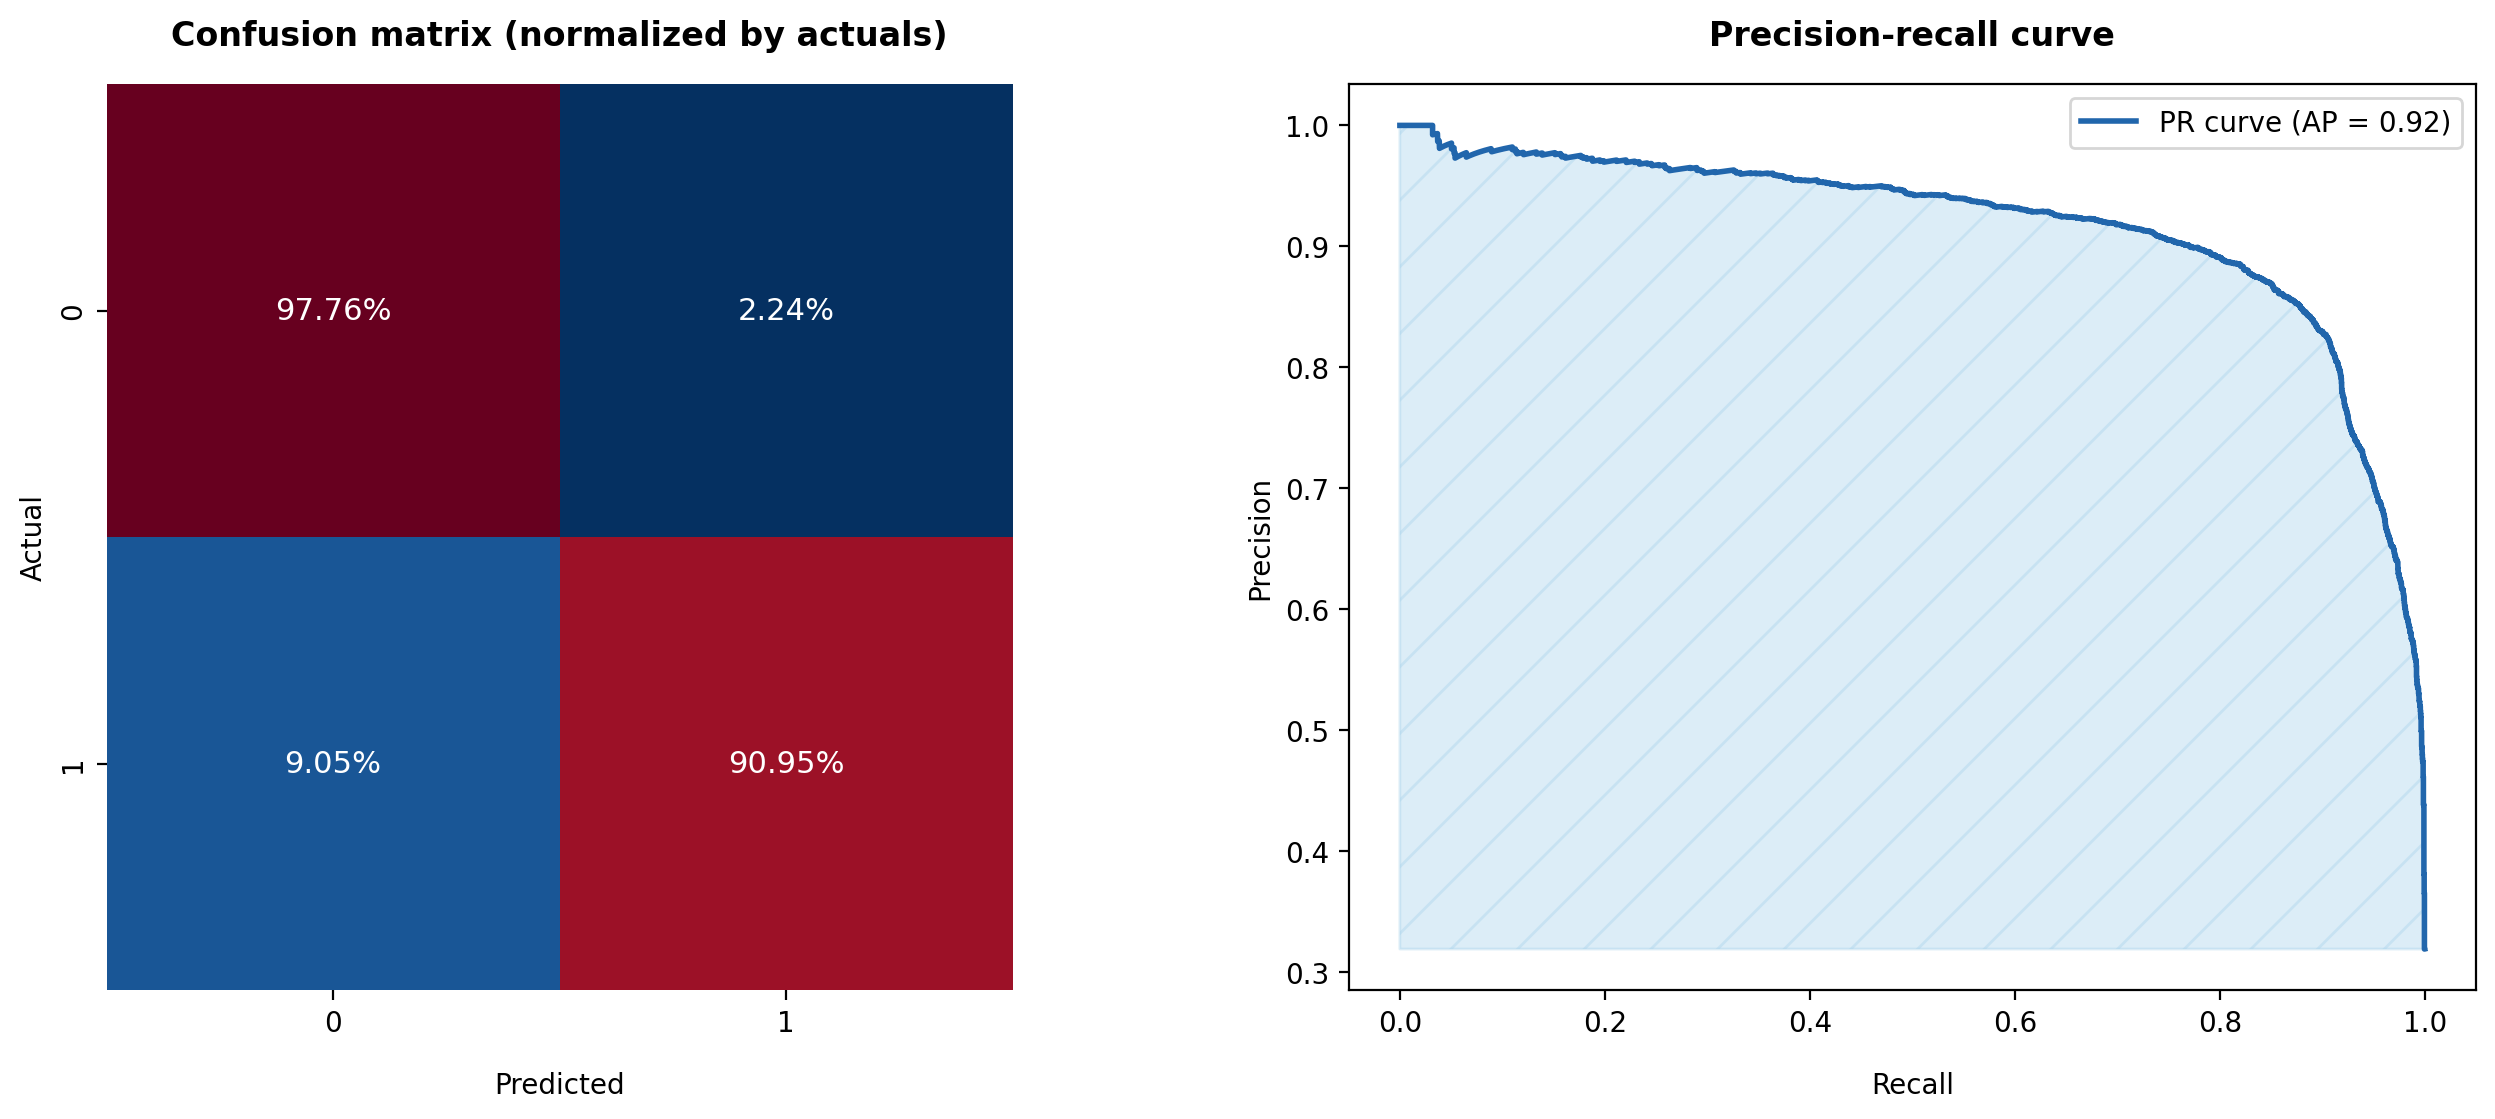

In [47]:
create_cm_pr(y_test, lgbm_pred_status, lgbm_proba_status)

**Insights**

- Hyperparameter tuning doesn't improve LightGBM performance. Nevertheless, classifier demonstrates a high skill to distinguish between classes. The percentage of false negatives are higher than false positives but this is expected due to class imbalance.
- LightGBM PR AUC is lower than XGBoost (trade-off between precision and recall is more visible - at very high recall, the precision begins to drop) but it still above 0.9 indicating a high skill of LightGBM to maintain a good balance between precision and recall.

#### Feature importance

In [48]:
explainer = shap.TreeExplainer(lgbm_pipe_status[-1])
shap_values = explainer.shap_values(X_test_tr)

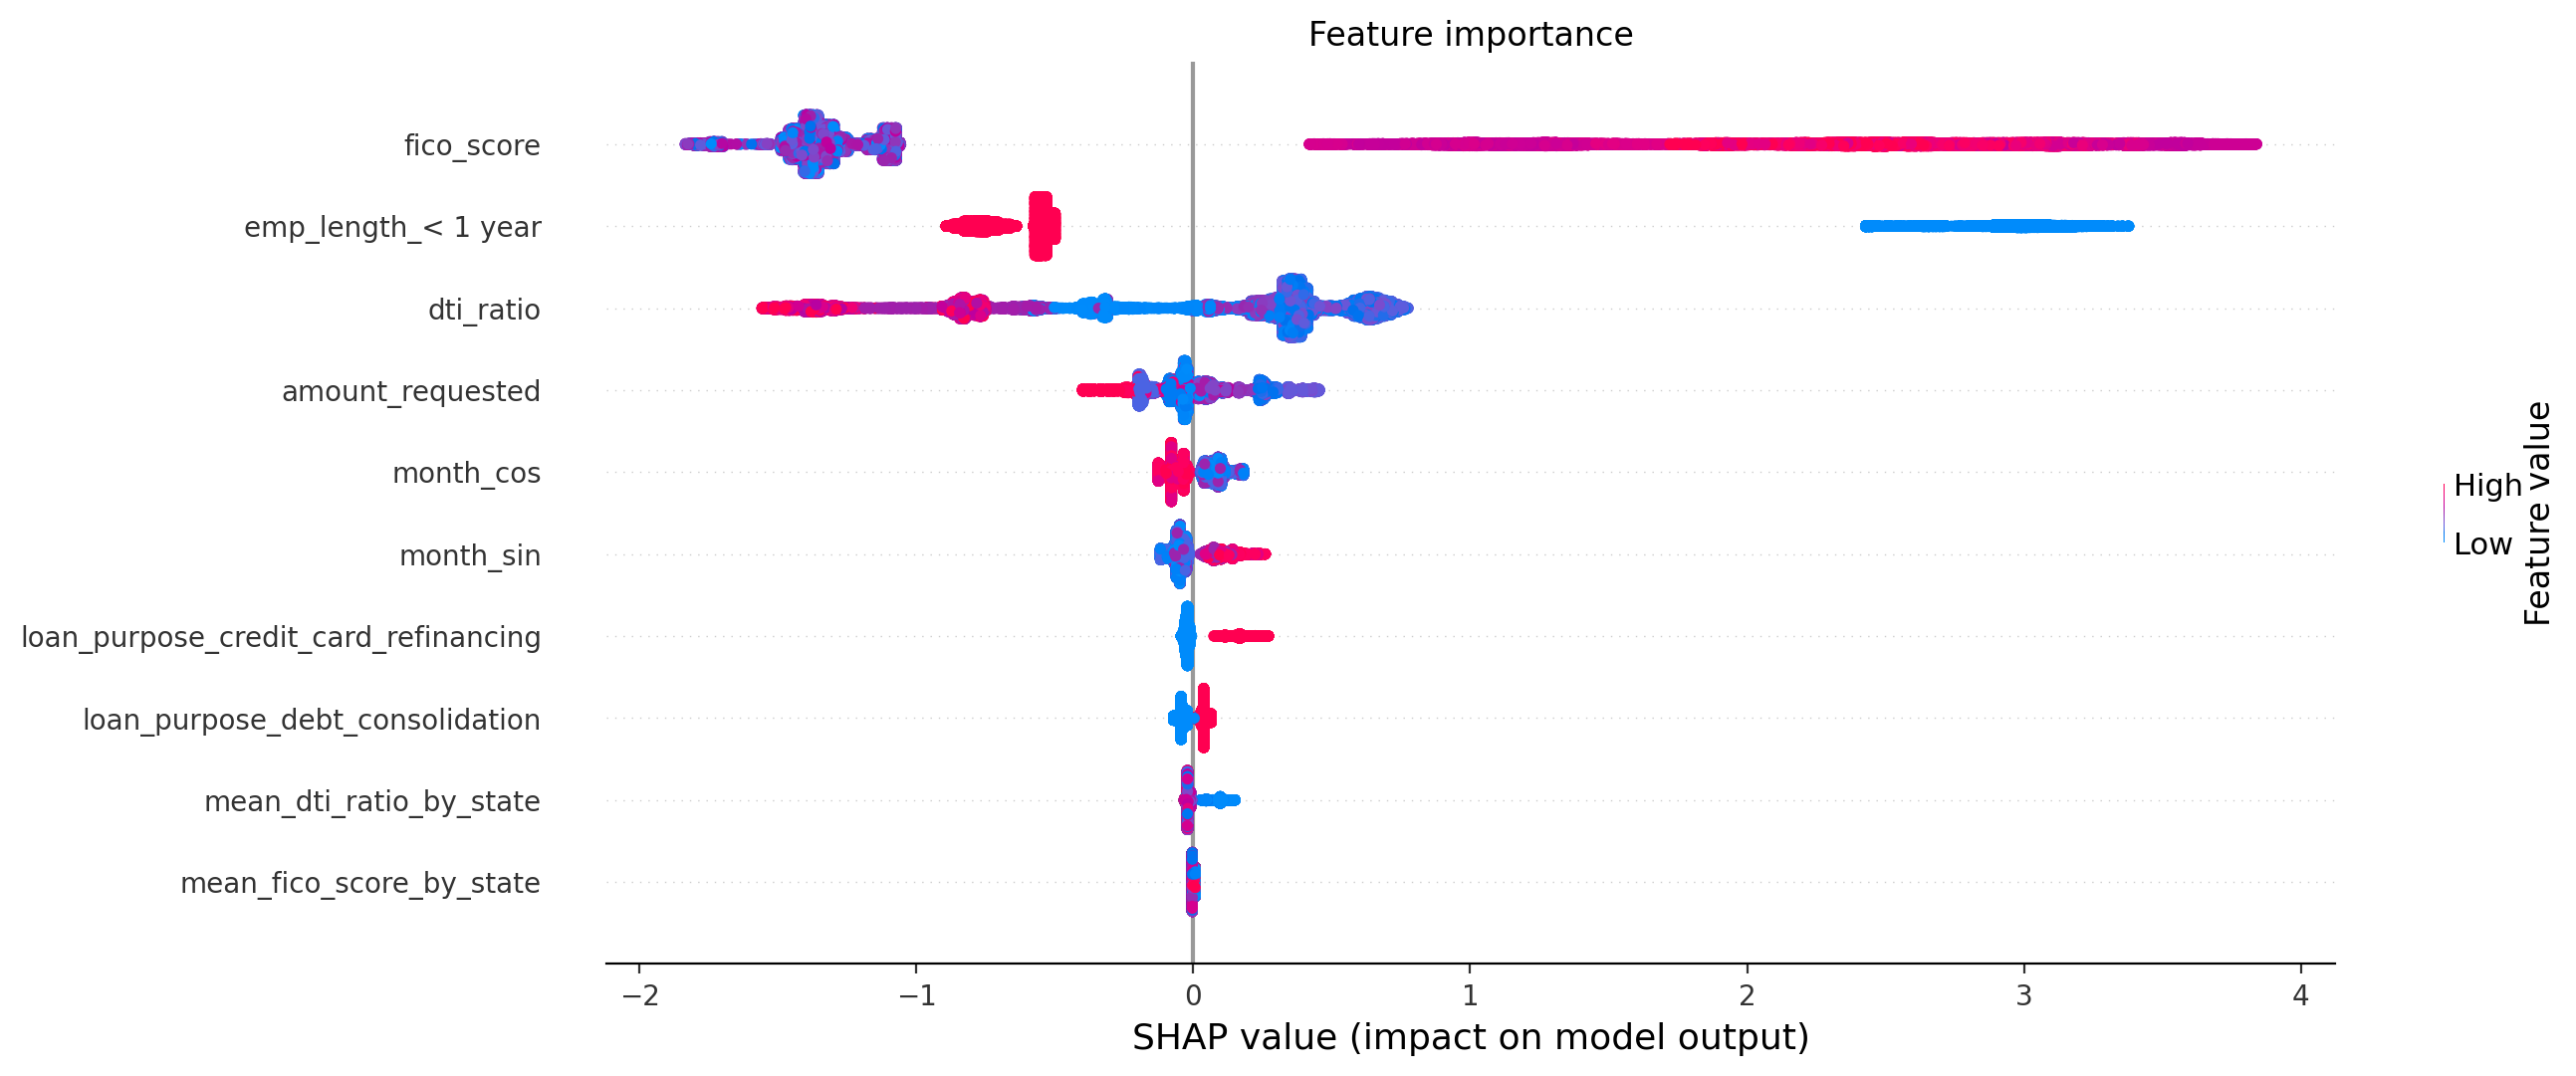

In [49]:
shap.summary_plot(
    shap_values[1],
    X_test_tr,
    feature_names=feature_names,
    max_display=10,
    show=False,
)

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches(14, 6)
ax.set_title("Feature importance", fontdict={"size": 12})
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=8)

**Insights**

- Top 4 most important features by LightGBM are the same as by XGBoost, however the order is slightly different - LightGBM gives more predictive power to the years of working experience:
    - `fico_score`
    - `emp_length_<1 year`
    - `dti_ratio`
    - `amount_requested`

#### Missclassified positive instances

In [50]:
misclassied_pos_lgbm = X_test[(y_test == 1) & (lgbm_pred_status == 0)]

misclassied_pos_lgbm.shape

(363, 7)

In [51]:
misclassied_pos_lgbm.sample(10)

amount_requested       date             loan_purpose  fico_score  \
93236             2400.0 2017-09-01                    other       707.0   
165920           16000.0 2017-07-01           major_purchase       662.0   
319010            3600.0 2017-06-01    moving_and_relocation       662.0   
735096           12000.0 2017-12-01       debt_consolidation       687.0   
315288            7000.0 2017-06-01  credit_card_refinancing       712.0   
165304           20000.0 2017-07-01       debt_consolidation       702.0   
799235           20950.0 2017-10-01       debt_consolidation       667.0   
699170           16000.0 2017-01-01       debt_consolidation       702.0   
727159            4000.0 2017-12-01                    other       662.0   
336839           24000.0 2017-06-01  credit_card_refinancing       712.0   

        dti_ratio state emp_length  
93236        6.25    NM   < 1 year  
165920       6.57    CA   < 1 year  
319010      28.85    CA   < 1 year  
735096      39.76    MA    3 years  
315288      11.64    CA   < 1 year  
165304      10.05    WA   < 1 year  
799235      24.34    KY   < 1 year  
699170      23.76    MA   < 1 year  
727159      22.54    FL   < 1 year  
336839      19.83    CA   < 1 year

**Insights**

- LightGBM missclassifies more than 300 instances.
- The pattern among missclassified instances is clear: almost all of them have employment length less than one year which is the dominant feature for rejected loan applications. 

In [52]:
acc_rej_pred_eval = append_cls_metrics(
    acc_rej_pred_eval,
    y_test,
    lgbm_pred_status,
    lgbm_proba_status,
    "Light GBM",
)

### Comparison of classifier results

In [53]:
acc_rej_pred_eval.set_index("Model").round(3)

Roc-auc  F1-score  Precision  Recall
Model                                          
XGBoost      0.998     0.964      0.938   0.933
Light GBM    0.991     0.922      0.815   0.909

**Insights**

- Even though XGBoost is a bit slower than LightGBM, it provides better results on chosen data sample (more than 100000 observations from 2017 data). 
- Before the deployment I fit the model to the full 2017 data (more than 4M observations) and evaluate performance on 2018 data (more than 1M observations) as a test set.

### Best classifier for 2017-2018 data

In [54]:
y_2017 = loans_2017["loan_status"]
X_2017 = loans_2017.drop(["loan_status"], axis=1)

In [55]:
X_train_2017, X_val_2017, y_train_2017, y_val_2017 = train_test_split(
    X_2017, y_2017, test_size=0.25, stratify=y_2017, random_state=RANDOM
)

In [56]:
xgb_pipe_status = Pipeline(
    steps=[
        ("feat_extractor", feat_extractor),
        ("preprocessor", preprocessor_app_status),
        (
            "XGBoot",
            xgb.XGBClassifier(
                objective="reg:logistic",
                use_label_encoder=False,
                **xgb_hp,
                random_state=RANDOM,
            ),
        ),
    ]
).fit(X_train_2017, y_train_2017)

In [57]:
# joblib.dump(xgb_pipe_status, "models/loan_app_status_classifier.pkl")

#### Training results - 2017 data

In [58]:
xgb_pred_status_2017 = xgb_pipe_status.predict(X_val_2017)
xgb_proba_status_2017 = xgb_pipe_status.predict_proba(X_val_2017)

In [59]:
print(
    "\033[1m" + "Classification report for test set with XGBoost:\n\n" + "\033[0m",
    classification_report(
        y_val_2017,
        xgb_pred_status_2017,
    ),
)

Classification report for test set with XGBoost:

               precision    recall  f1-score   support

           0       0.99      0.99      0.99    924729
           1       0.94      0.95      0.94    100284

    accuracy                           0.99   1025013
   macro avg       0.97      0.97      0.97   1025013
weighted avg       0.99      0.99      0.99   1025013



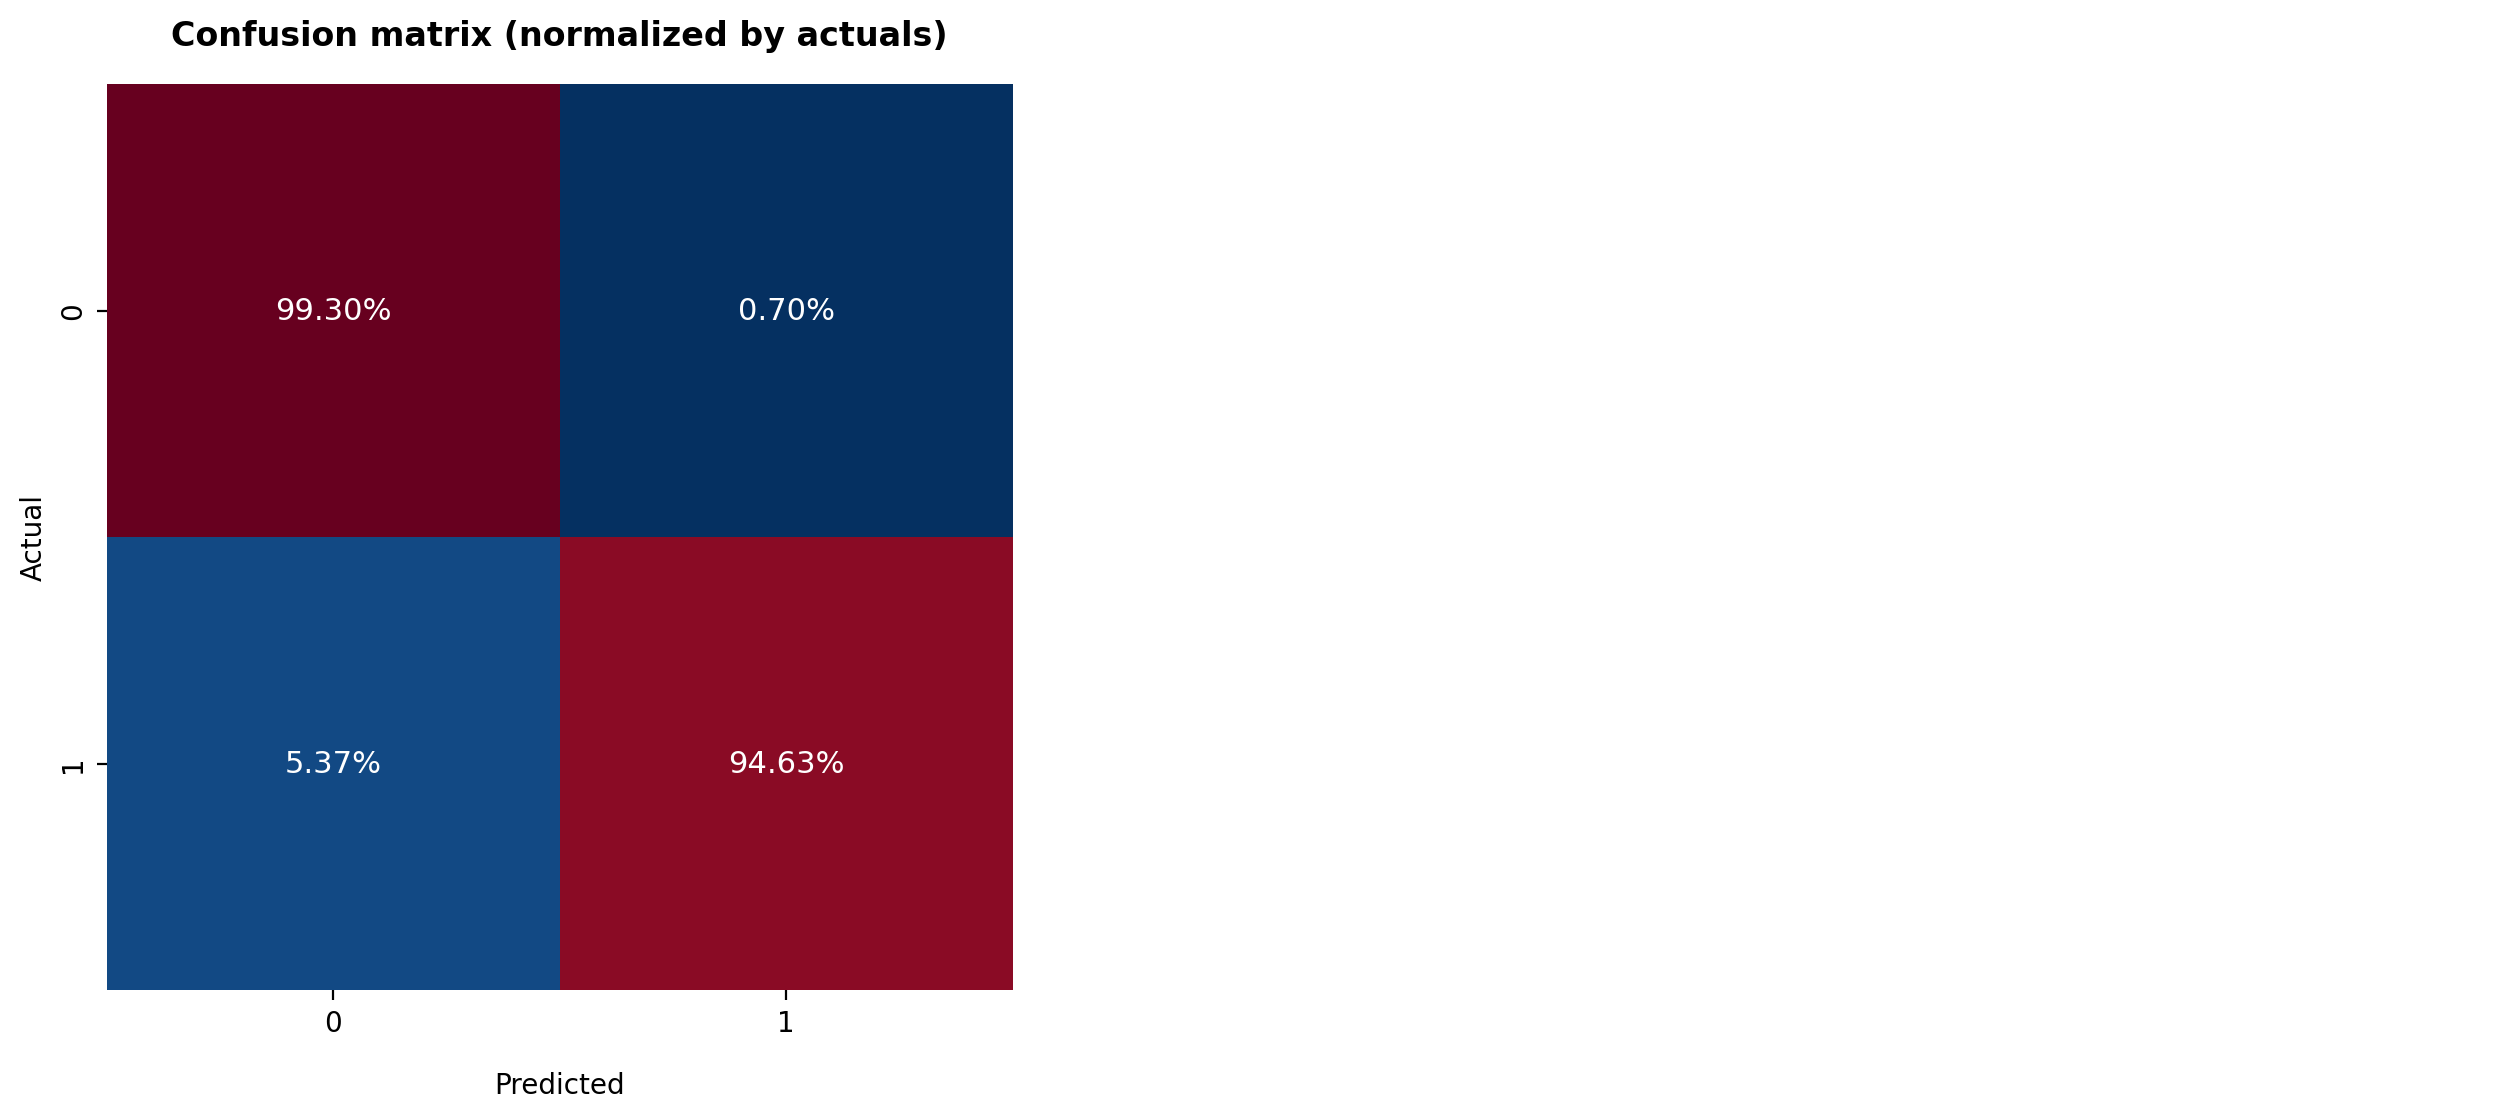

In [60]:
create_confusion(y_val_2017, xgb_pred_status_2017)

**Insights**

- Training on larger dataset improves prediction results and XGBoost shows almost perfect skill to correctly classify class 0. 
- Class 1 predictions has around 5% of missclassified instances but it is relatively small error.
- PR AUC shows an outstanding XGBoost performance on balancing precision and recall for minority class.

#### Model evaluation - 2018 data

In [61]:
y_2018 = loans_2018["loan_status"]
X_2018 = loans_2018.drop(["loan_status"], axis=1)

In [62]:
xgb_pred_status_2018 = xgb_pipe_status.predict(X_2018)
xgb_proba_status_2018 = xgb_pipe_status.predict_proba(X_2018)

In [63]:
print(
    "\033[1m" + "Classification report for test set with XGBoost:\n\n" + "\033[0m",
    classification_report(
        y_2018,
        xgb_pred_status_2018,
    ),
)

Classification report for test set with XGBoost:

               precision    recall  f1-score   support

           0       0.94      0.99      0.96    625011
           1       0.99      0.90      0.94    426239

    accuracy                           0.96   1051250
   macro avg       0.96      0.95      0.95   1051250
weighted avg       0.96      0.96      0.96   1051250



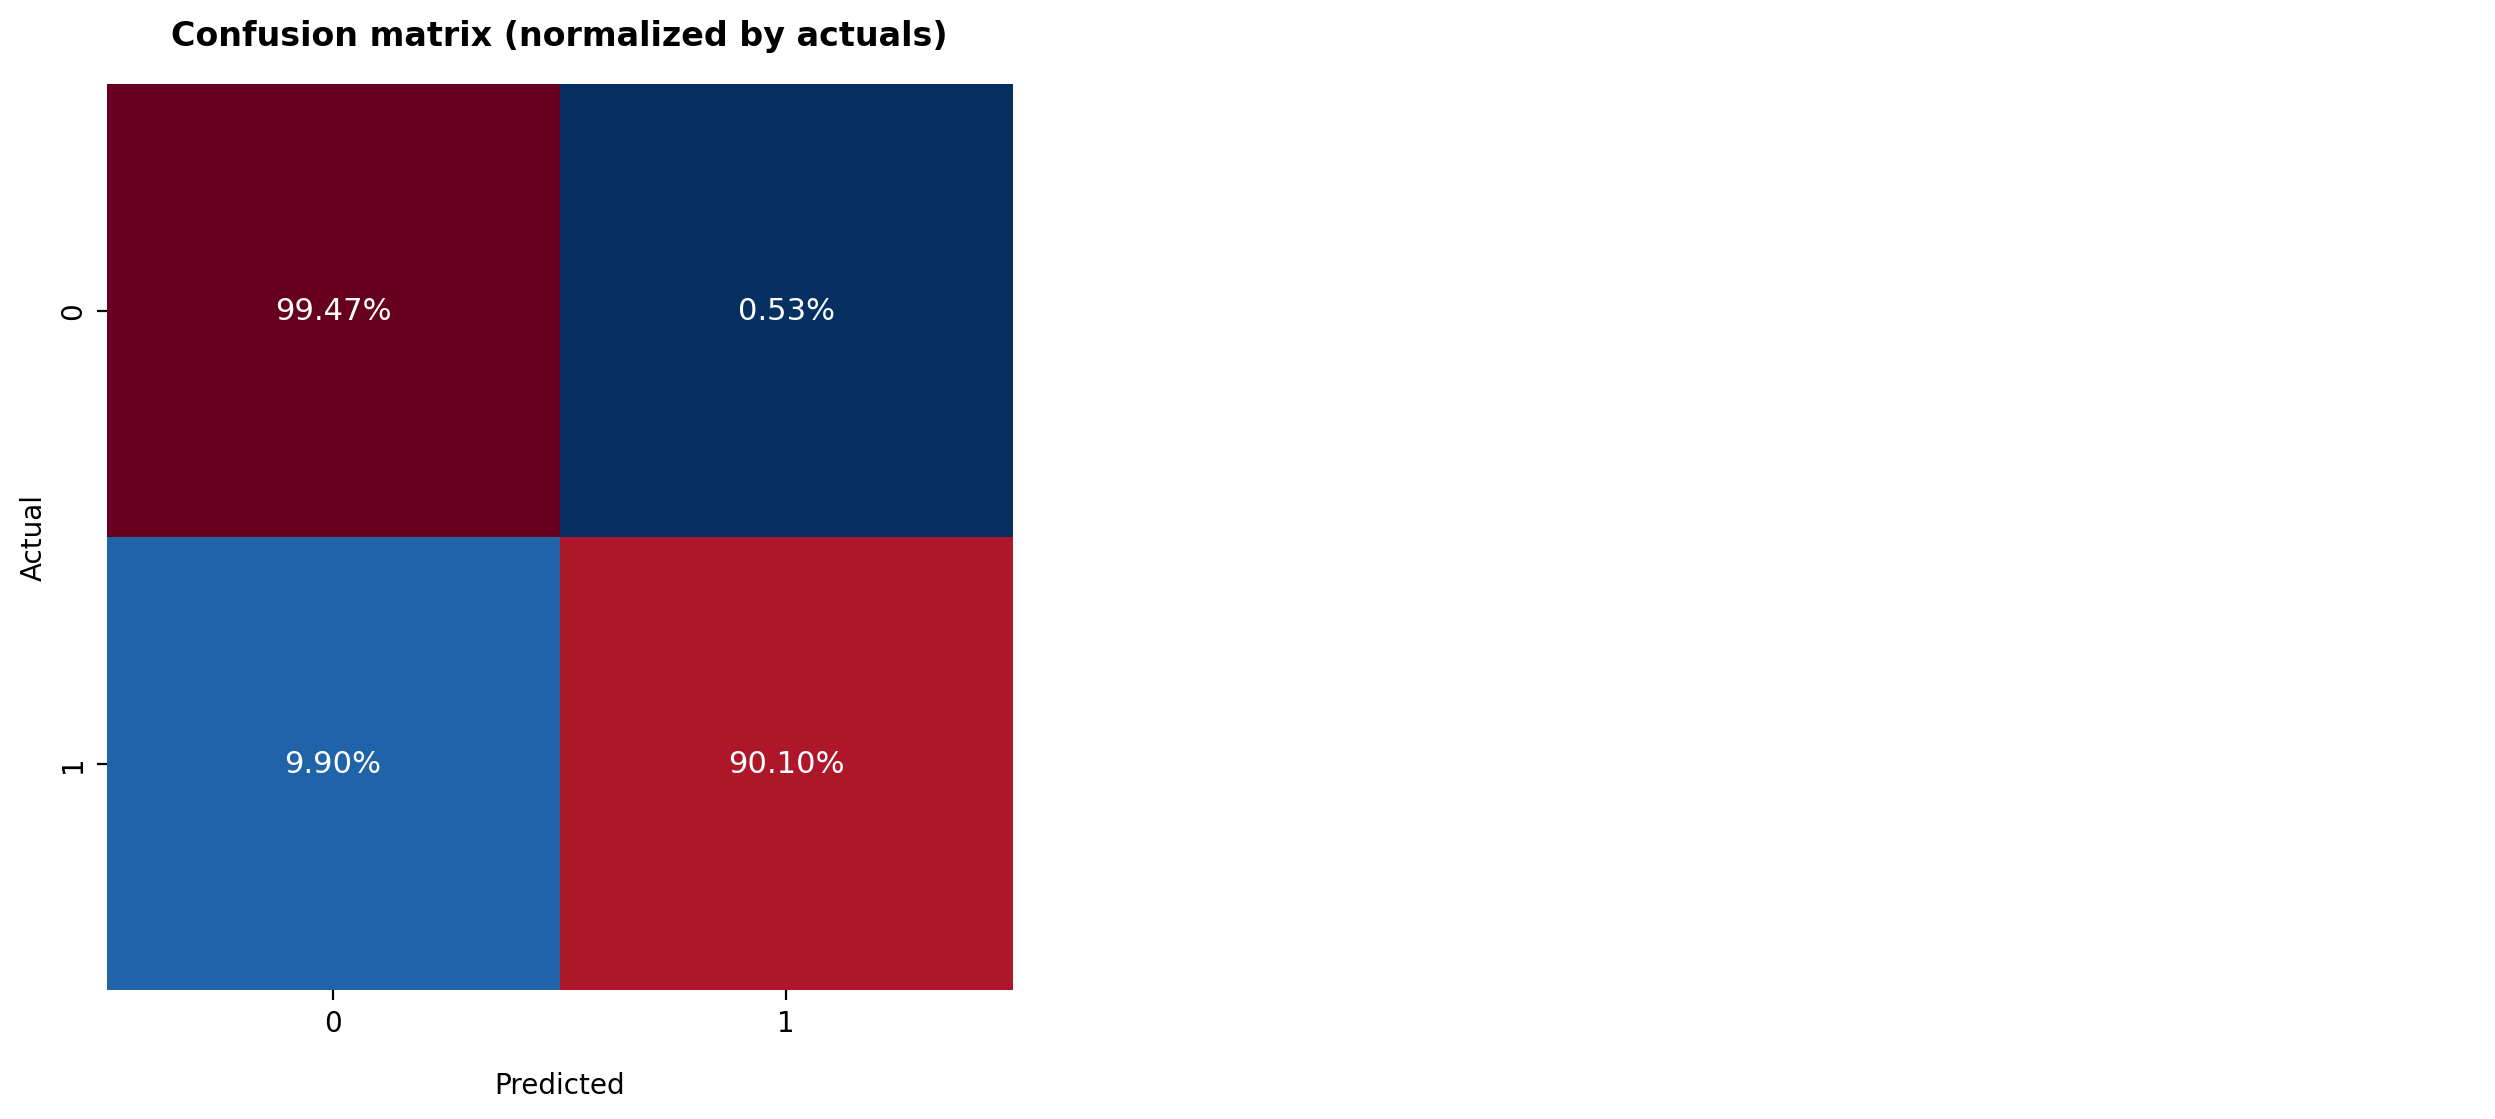

In [64]:
create_confusion(y_2018, xgb_pred_status_2018)

#### Example of adjusting threshold

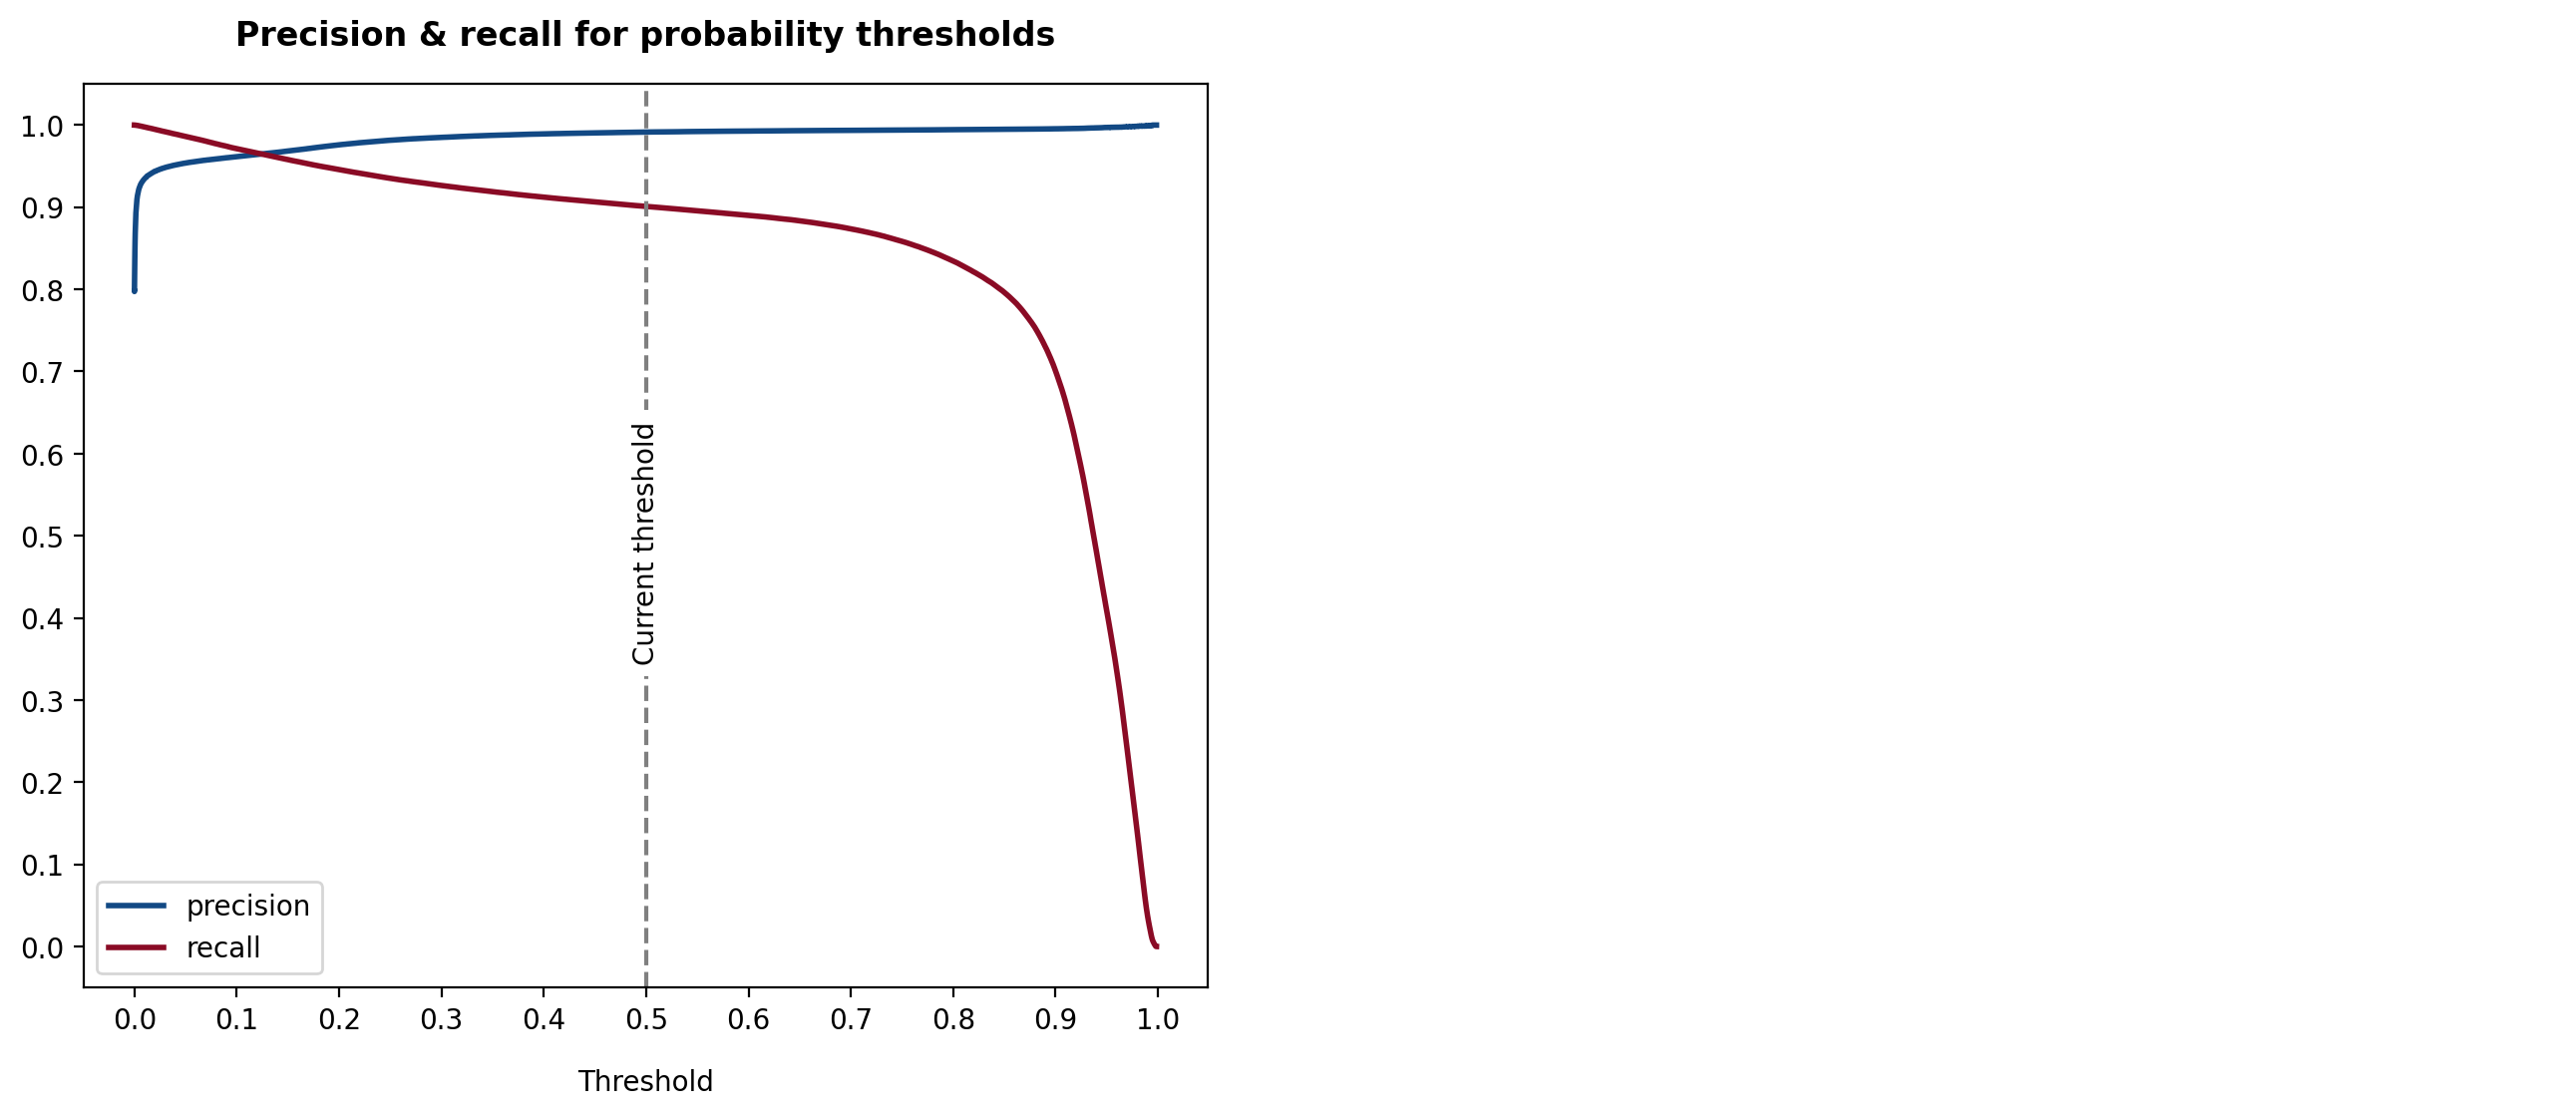

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

precision, recall, threshold = precision_recall_curve(
        y_2018, xgb_proba_status_2018[:, 1], pos_label=1
    )
plot_prec_recall_vs_tresh(precision, recall, threshold, ax[0])

ax[1].axis("off")
plt.show()

In [66]:
pred_log_adjusted = np.where(xgb_proba_status_2018[:, 1] > 0.2, 1, 0)

In [67]:
print(
    "\033[1m" + "Classification report for Logistic Regression:\n\n" + "\033[0m",
    classification_report(
        y_2018,
        pred_log_adjusted,
    ),
)

Classification report for Logistic Regression:

               precision    recall  f1-score   support

           0       0.96      0.98      0.97    625011
           1       0.98      0.95      0.96    426239

    accuracy                           0.97   1051250
   macro avg       0.97      0.96      0.97   1051250
weighted avg       0.97      0.97      0.97   1051250



**Insights**

- Testing model performance on unseen 2018 data shows a slight decrease in F1-score due to the decrease in recall of class 1. It might be useful to try out different thresholds to level precision and recall for class 1.
- In general model still shows a high skill to distinguish between classes indicating that features in this dataset are sufficient to make future predictions.

***

## Loan ranking - grade, sub-grade & interest rate

**Intro**

Loan grade determines the interest rate and fees. Lending Club’s interest rates take into account credit risk and market conditions. 
The final interest rate for each loan grade is the result of the following equation: *Lending Club Base Rate + Adjustment for Risk & Volatility*. The Adjustment for Risk & Volatility is designed to cover expected losses and provide higher risk-adjusted returns for each loan grade increment from A1 to G5. 

Reference: https://www.lendingclub.com/foliofn/rateDetail.action

**Approach**
- Loan grading or scoring is a part of loan application pre-processing after approval (steps that are done before issuing the loan to borrower) and not with the loan performance or repayment, therefore quite many features are removed from accepted loans' dataset because they are not relevant for grade, sub-grade and interest rate prediction. 
- Grade prediction:
    - The sample of more than 100000 observations was taken for grade prediction before fitting the final model to full data for 2017-2018
    - Loan grade is a primary (initial) rank that is assigned to the loan as the assessment of the loan risk before assigning sub-grade or interest rate. Accordingly, I removed sub-grade and interest rate as features for grade prediction.
- Sub-grade prediction:
    - Loan sub-grade is determined within the range of each grade as per LendingClub terms and conditions. Accordingly, I decided to predict sub-grade for each grade separately.
- Interest rate prediction:
    - Predicting interest rate by grade seemed logical approach but it provided very low results (experiment could be found in Annex). Therefore I have decided to apply regressor for interest rate prediction regardless of grade.

### Data cleaning & preprocessing

In [68]:
accepted = pd.read_csv("accepted.csv", low_memory=False)

In [69]:
accepted = accepted.drop(accepted[accepted["application_type"] == "joint_app"].index)
accepted = accepted.drop(columns=["application_type"])

In [70]:
cols_with_high_missing = accepted.columns[
    ((accepted.isnull().sum() / accepted.shape[0]) * 100 > 60).values
]

In [71]:
cols_to_drop = [
    "id",
    "funded_amnt",
    "funded_amnt_inv",
    "installment",
    "pymnt_plan",
    "emp_title",
    "title",
    "url",
    "zip_code",
    "delinq_2yrs",
    "revol_bal",
    "next_pymnt_d",
    "initial_list_status",
    "out_prncp",
    "out_prncp_inv",
    "total_pymnt",
    "total_pymnt_inv",
    "total_rec_prncp",
    "total_rec_int",
    "total_rec_late_fee",
    "recoveries",
    "collection_recovery_fee",
    "last_pymnt_d",
    "last_pymnt_amnt",
    "last_credit_pull_d",
    "last_fico_range_high",
    "last_fico_range_low",
    "collections_12_mths_ex_med",
    "collection_recovery_fee",
    "policy_code",
    "acc_now_delinq",
    "chargeoff_within_12_mths",
    "delinq_amnt",
    "loan_status",
    "tax_liens",
    "hardship_flag",
    "disbursement_method",
    "debt_settlement_flag",
]

In [72]:
accepted = accepted.drop(cols_with_high_missing, axis=1)
accepted = accepted.drop(columns=cols_to_drop)

In [73]:
for col in accepted.columns:
    if col.startswith("mths"):
        accepted[col] = accepted[col].fillna(0)

In [74]:
accepted["emp_length"] = accepted["emp_length"].fillna("not_provided")

In [75]:
accepted_missing = (
    (accepted.isnull().sum() * 100 / len(accepted))
    .to_frame()
    .rename(columns={0: "percent_missing"})
    .round(2)
)
accepted_missing.sort_values(by="percent_missing", ascending=False).head(12)

percent_missing
il_util                         15.19
num_tl_120dpd_2m                 3.69
mo_sin_old_il_acct               3.36
bc_util                          1.36
percent_bc_gt_75                 1.32
bc_open_to_buy                   1.31
dti                              0.18
revol_util                       0.11
all_util                         0.02
avg_cur_bal                      0.01
loan_amnt                        0.00
mths_since_recent_bc             0.00

In [76]:
accepted = accepted.dropna()

In [77]:
accepted.shape

(749786, 71)

***

## Grade predicion

**Approach**

- I chose macro F1-score as the main metric for classifier evaluation because all loan grades are equally important. (Macro f1-score is low for models that only perform well on the common classes while performing poorly on the rare classes)
- For pre-processing and hyperparameter tuning the small amount of data is sampled to speed things up and at the end the final model is fitted on the whole dataset fro 2017-2018.

In [78]:
accepted_grade = accepted.drop(columns=["sub_grade", "int_rate"])

In [79]:
accepted_grade["grade"] = accepted_grade["grade"].map(
    {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6}
)

In [80]:
grade_sample = accepted_grade.groupby("grade", group_keys=False).apply(
    lambda x: x.sample(frac=0.2)
)
grade_sample.shape

(149957, 69)

### Feature selection

For feature selection I have combined two techniques: correlation and mutual information (mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other), by taking the list of 20 most correlated features and merging the list of 20 top features with the highest MI score.

In [81]:
top_grade_features = select_top_features(grade_sample, "grade")

In [82]:
additional_append_lst = ["annual_inc", "emp_length", "purpose", "grade", 'earliest_cr_line']

for col in additional_append_lst:
    if col not in top_grade_features:
        top_grade_features.append(col)

In [83]:
grade_sample = grade_sample[top_grade_features].copy()

In [84]:
grade_sample.shape

(149957, 31)

### Pre-processing

In [85]:
y_g = grade_sample["grade"]
X_g = grade_sample.drop(["grade"], axis=1)

In [86]:
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    X_g, y_g, test_size=0.25, stratify=y_g, random_state=RANDOM
)

In [87]:
year = FunctionTransformer(get_cr_line_year, check_inverse=False)
month = FunctionTransformer(get_multi_month, check_inverse=False)

In [88]:
numeric_features_g = list(X_g.select_dtypes(include=["float64"]).columns)
numeric_features_g.extend(["cr_line_year", "issue_month", "cr_line_month"])
categorical_features_g = ["term", "verification_status", "purpose", "emp_length",]

In [89]:
feat_extractor_g = Pipeline(
    steps=[
        ("year", year),
        ("month", month),
    ]
)

In [90]:
categorical_transformer_g = Pipeline(
    steps=[("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))]
)

numeric_transformer_g = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

preprocessor_g = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer_g, categorical_features_g),
        ("numeric", numeric_transformer_g, numeric_features_g),
    ],
    remainder="passthrough",
)

In [91]:
pipe_transform_g = Pipeline(
    steps=[
        ("feat_extractor_g", feat_extractor_g),
        ("preprocessor_g", preprocessor_g),
    ]
)

### Model selection

In [92]:
classifiers_grade = [
    ("Dummy Classifier", DummyClassifier(strategy="stratified")),
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Random Forest", RandomForestClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    (
        "XGBoost",
        xgb.XGBClassifier(
            objective="multi:softprob", use_label_encoder=False, eval_metric="mlogloss"
        ),
    ),
    ("LightGBM", lgb.LGBMClassifier(objective="multiclass", verbosity=-1)),
]

In [93]:
X_train_g_tr = pipe_transform_g.fit_transform(X_train_g)

In [94]:
cls_comparison = compare_multiclass_cls(classifiers_grade, X_train_g_tr, y_train_g)
cls_comparison = cls_comparison.set_index("Classifier")

cls_comparison.style.format("{0:,.3f}").background_gradient(cmap='Blues', subset=['F1-score'])

**Insights**

- Low primary results indicate that features in this dataset are not really suitable for loan grade prediction and classifiers are having difficulties in distinguishing among grades.
- LightGBM provides the highest F1-score and was chosen for further tuning.

### LightGBM

#### HP tuning

In [95]:
sampler = TPESampler(seed=RANDOM)
study_multi_lgbm = optuna.create_study(direction="maximize", sampler=sampler)
study_multi_lgbm.optimize(
    lambda trial: objective_multi_lgbm(trial, X_train_g, y_train_g, pipe_transform_g),
    n_trials=10,
    show_progress_bar=True,
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [96]:
print("Best F1-score on validation set:", str(round(study_multi_lgbm.best_value, 3)))

Best F1-score on validation set: 0.319


In [97]:
lgbm_hp = study_multi_lgbm.best_params

lgbm_pipe_grade = Pipeline(
    steps=[
        ("feat_extractor_g", feat_extractor_g),
        ("preprocessor_g", preprocessor_g),
        (
            "classifier",
            lgb.LGBMClassifier(
                objective="multiclass",
                class_weight="balanced",
                verbosity=-1,
                **lgbm_hp,
                random_state=RANDOM,
            )
        ),
    ]
).fit(X_train_g, y_train_g)

[LightGBM] [Warning] min_data_in_leaf is set=620, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=620
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


#### Training results

In [98]:
lgbm_pred_grade_train = lgbm_pipe_grade.predict(X_train_g)

In [99]:
print(
    "\033[1m" + "Classification report for train set with LightGBM:\n\n" + "\033[0m",
    classification_report(y_train_g, lgbm_pred_grade_train, target_names=["A", "B", "C", "D", "E", "F", "G"]),
)

Classification report for train set with LightGBM:

               precision    recall  f1-score   support

           A       0.66      0.75      0.70     25939
           B       0.49      0.50      0.49     32488
           C       0.50      0.24      0.32     32556
           D       0.29      0.23      0.26     15127
           E       0.15      0.32      0.21      4666
           F       0.10      0.70      0.18      1162
           G       0.09      0.88      0.16       529

    accuracy                           0.44    112467
   macro avg       0.33      0.52      0.33    112467
weighted avg       0.49      0.44      0.44    112467



#### Model evaluation

In [100]:
lgbm_pred_grade = lgbm_pipe_grade.predict(X_test_g)

In [101]:
print(
    "\033[1m" + "Classification report for test set with LightGBM:\n\n" + "\033[0m",
    classification_report(
        y_test_g,
        lgbm_pred_grade,
        target_names=["A", "B", "C", "D", "E", "F", "G"]
    ),
)

Classification report for test set with LightGBM:

               precision    recall  f1-score   support

           A       0.66      0.73      0.70      8647
           B       0.47      0.49      0.48     10829
           C       0.49      0.23      0.31     10852
           D       0.27      0.21      0.24      5043
           E       0.12      0.25      0.16      1556
           F       0.06      0.38      0.10       387
           G       0.04      0.44      0.08       176

    accuracy                           0.42     37490
   macro avg       0.30      0.39      0.30     37490
weighted avg       0.47      0.42      0.43     37490



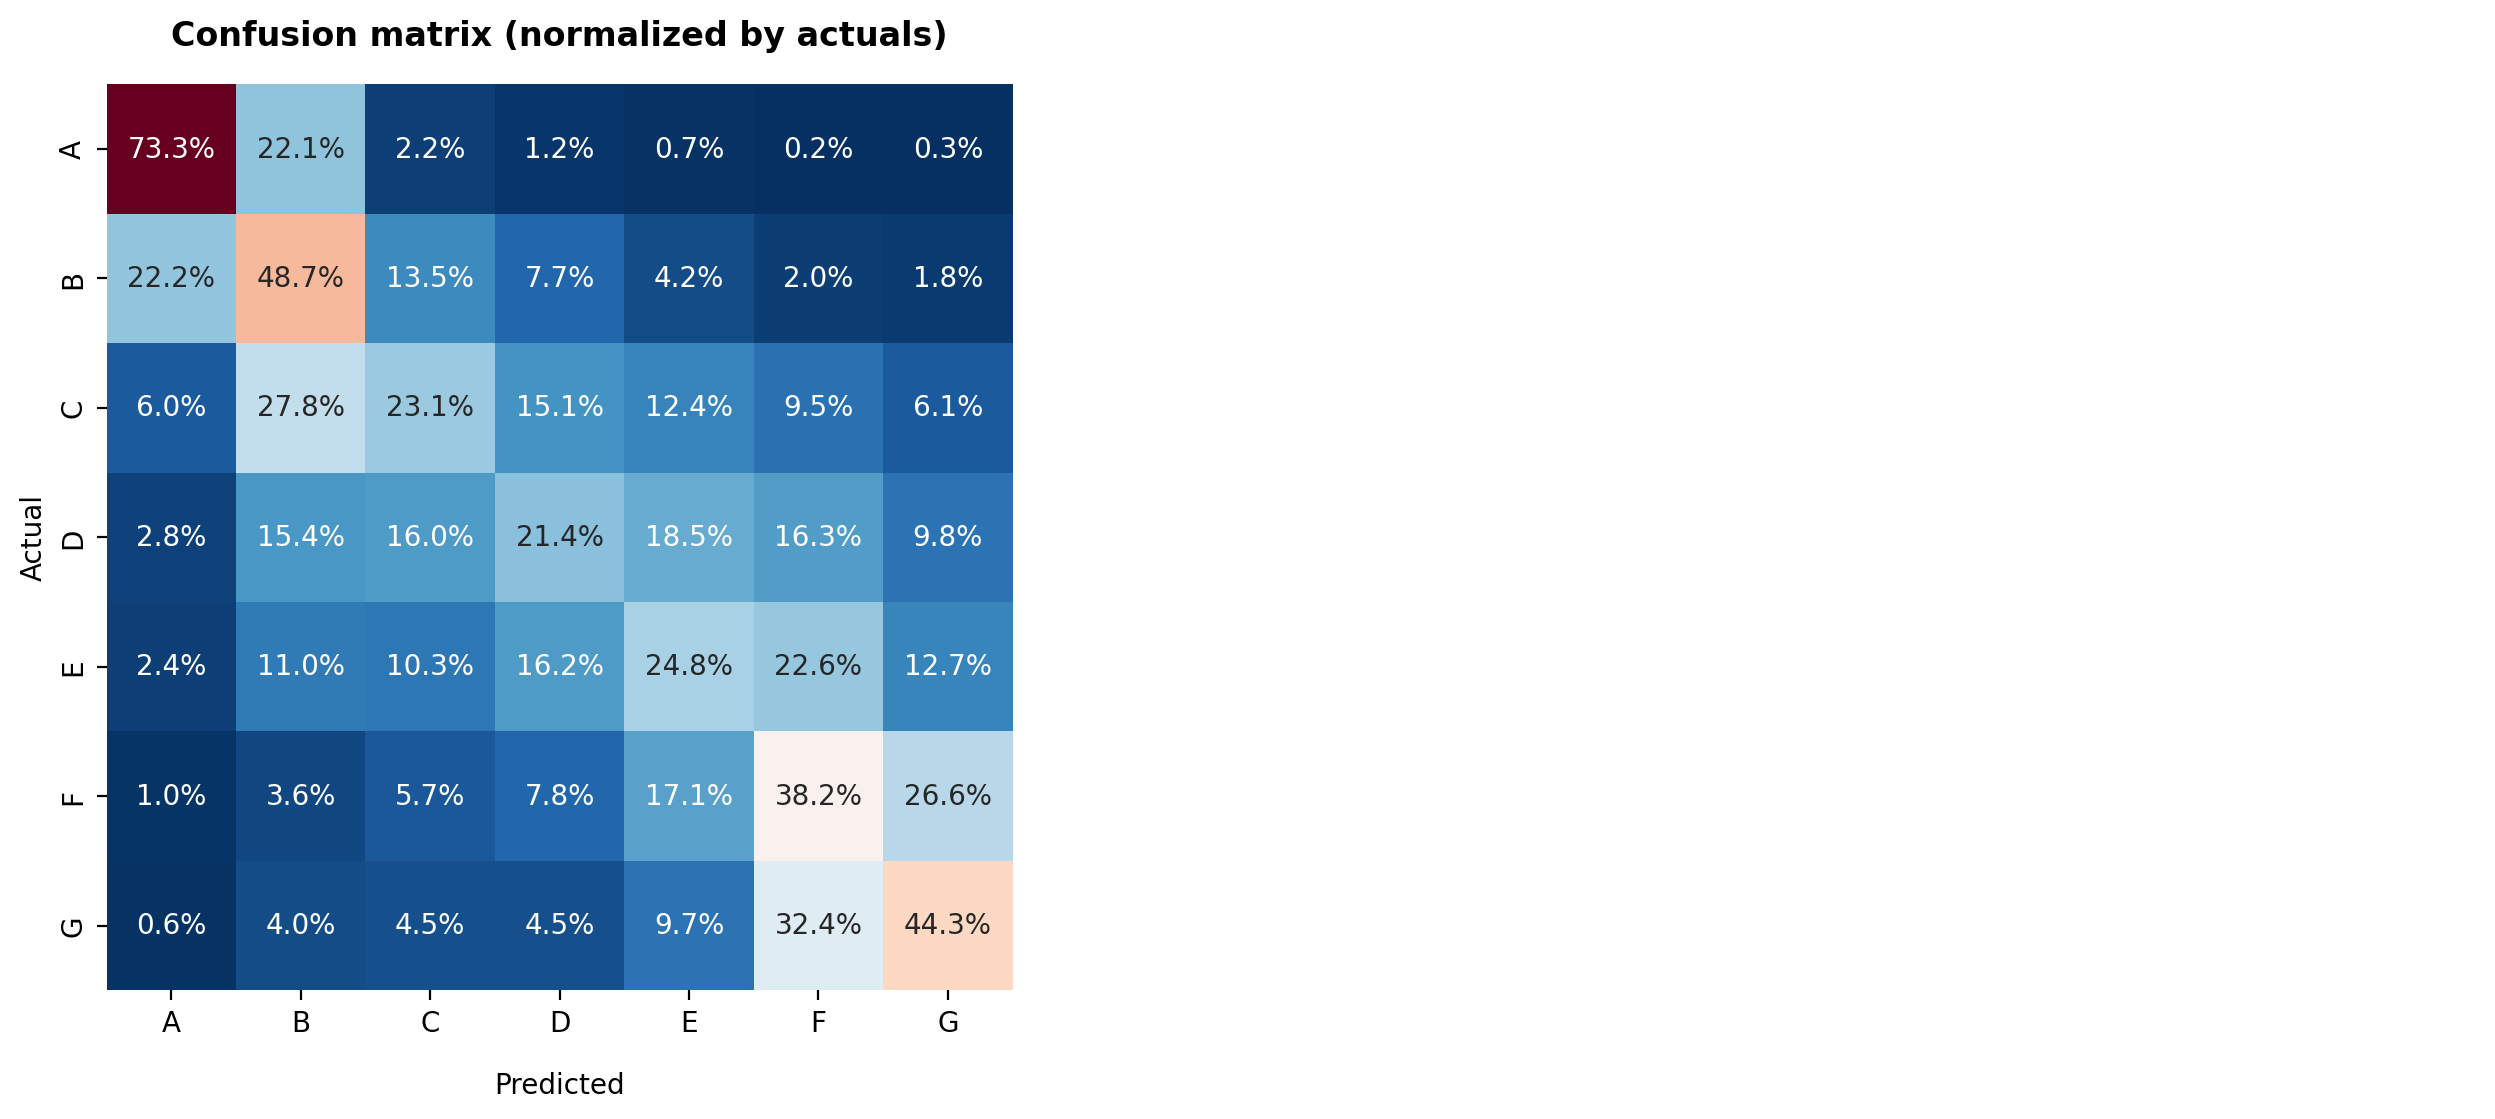

In [102]:
create_multi_cm(y_test_g, lgbm_pred_grade)

**Insights**

- HP tuning doesn't really improve the model performance.
- Confusion matrix shows that model is having difficulties distinguishing between close classes (grades). For example, grade C is frequently classified as class B and D.
- I was expecting more accurate predictions made for grades that have more observations (for example, grade C) but it seems that categories (grades) that have more evident value predominance for top features have higher number of hits (higher recall).

#### Feature importance

In [103]:
feature_names_g = list(lgbm_pipe_grade[1].transformers_[0][1].get_feature_names_out())

In [104]:
feature_names_g.extend(numeric_features_g)

In [105]:
X_test_g_tr = lgbm_pipe_grade[:-1].transform(X_test_g)
explainer = shap.TreeExplainer(lgbm_pipe_grade[-1])
shap_values = explainer.shap_values(X_test_g_tr)

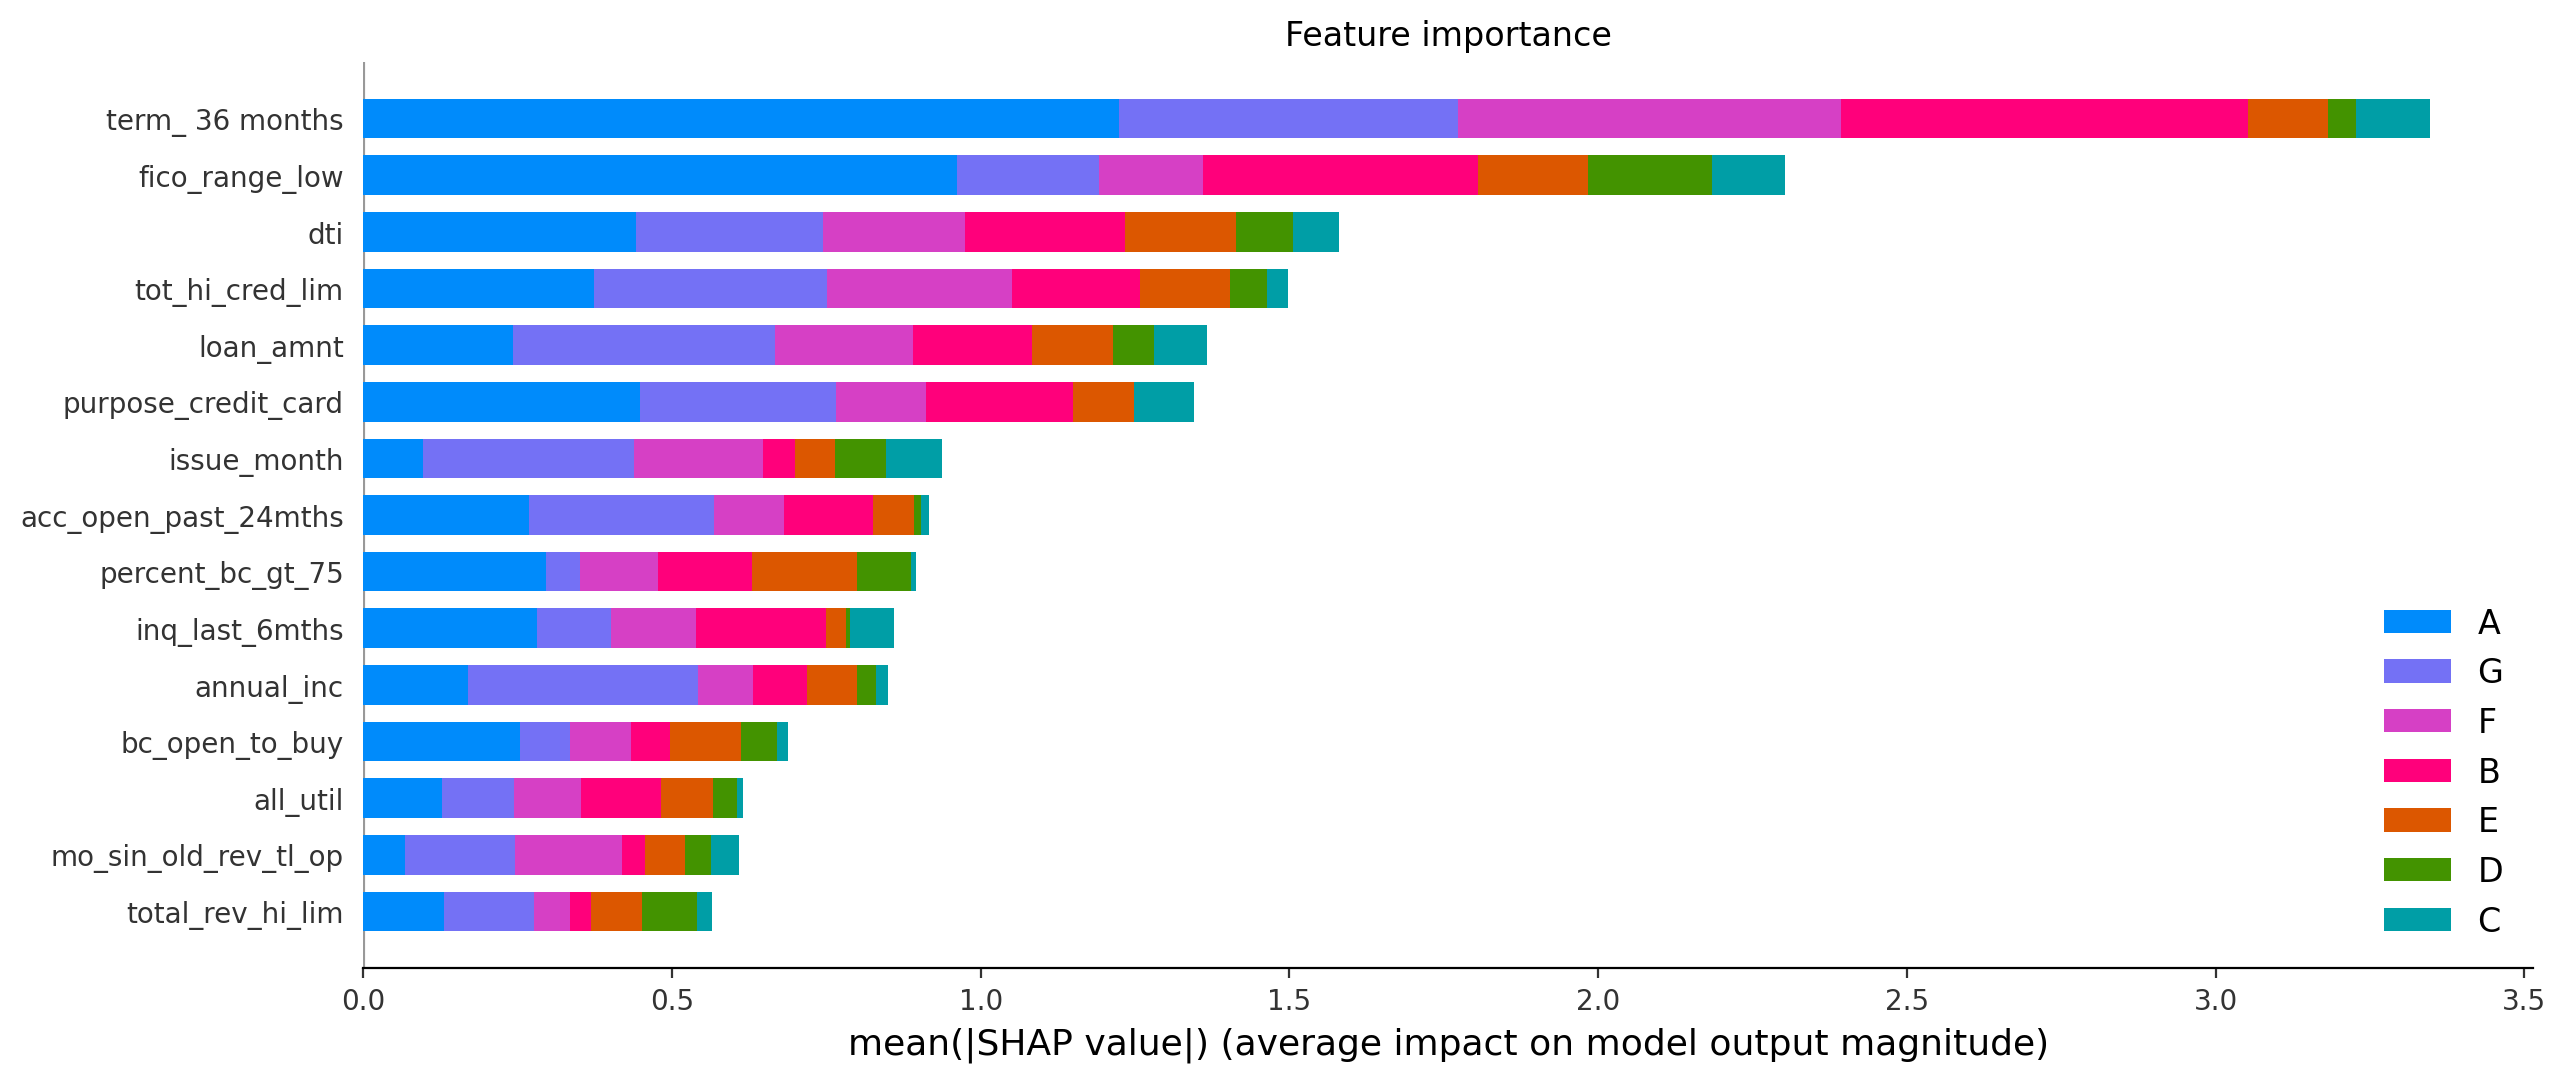

In [106]:
shap.summary_plot(
    shap_values,
    X_test_g_tr,
    feature_names=feature_names_g,
    max_display=15,
    show=False,
    class_names=["A", "B", "C", "D", "E", "F", "G"]
)

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches(14, 6)
ax.set_title("Feature importance", fontdict={"size": 12})
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=8)

**Insights**

- The top 4 most important features for grade prediction are:
    - `term_36 months`
    - `fico_range low`
    - `dti`
    - `loan_amnt`
- These features mostly help to identify classes that have clear(ish) value predominance. For example most loans for grade A have term of 36 months while most loans for grade G have term of 60 months. This difference is not so visible for other grades, they have almost 50/50 split regarding loan term. 

### Best classifier for 2017-2018 data

In [107]:
accepted_grade = accepted_grade[top_grade_features].copy()

In [108]:
y_g = accepted_grade["grade"]
X_g = accepted_grade.drop(["grade"], axis=1)

In [109]:
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    X_g, y_g, test_size=0.25, stratify=y_g, random_state=RANDOM
)

In [110]:
lgbm_hp = study_multi_lgbm.best_params

lgbm_pipe_grade = Pipeline(
    steps=[
        ("feat_extractor_g", feat_extractor_g),
        ("preprocessor_g", preprocessor_g),
        (
            "classifier", 
            lgb.LGBMClassifier(
                objective="multiclass",
                class_weight="balanced",
                verbosity=-1,
                **lgbm_hp,
                random_state=RANDOM,
            )
        ),
    ]
).fit(X_train_g, y_train_g)

[LightGBM] [Warning] min_data_in_leaf is set=620, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=620
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


In [111]:
# joblib.dump(lgbm_pipe_grade, "models/grade_classifier.pkl")

#### Training results

In [112]:
lgbm_pred_grade_max_train = lgbm_pipe_grade.predict(X_train_g)

In [113]:
print(
    "\033[1m" + "Classification report for train set with LightGBM:\n\n" + "\033[0m",
    classification_report(y_train_g, lgbm_pred_grade_max_train, target_names=["A", "B", "C", "D", "E", "F", "G"]),
)

Classification report for train set with LightGBM:

               precision    recall  f1-score   support

           A       0.67      0.75      0.71    129699
           B       0.49      0.49      0.49    162437
           C       0.50      0.28      0.36    162782
           D       0.30      0.24      0.26     75638
           E       0.15      0.23      0.18     23331
           F       0.08      0.53      0.13      5810
           G       0.06      0.70      0.12      2642

    accuracy                           0.44    562339
   macro avg       0.32      0.46      0.32    562339
weighted avg       0.49      0.44      0.45    562339



#### Model evaluation

In [114]:
lgbm_pred_grade_max = lgbm_pipe_grade.predict(X_test_g)

In [115]:
print(
    "\033[1m" + "Classification report for test set with LightGBM:\n\n" + "\033[0m",
    classification_report(
        y_test_g,
        lgbm_pred_grade_max,
        target_names=["A", "B", "C", "D", "E", "F", "G"]
    ),
)

Classification report for test set with LightGBM:

               precision    recall  f1-score   support

           A       0.67      0.75      0.70     43233
           B       0.49      0.49      0.49     54146
           C       0.49      0.27      0.35     54260
           D       0.29      0.23      0.25     25213
           E       0.13      0.20      0.16      7777
           F       0.06      0.41      0.10      1937
           G       0.05      0.52      0.09       881

    accuracy                           0.44    187447
   macro avg       0.31      0.41      0.31    187447
weighted avg       0.48      0.44      0.45    187447



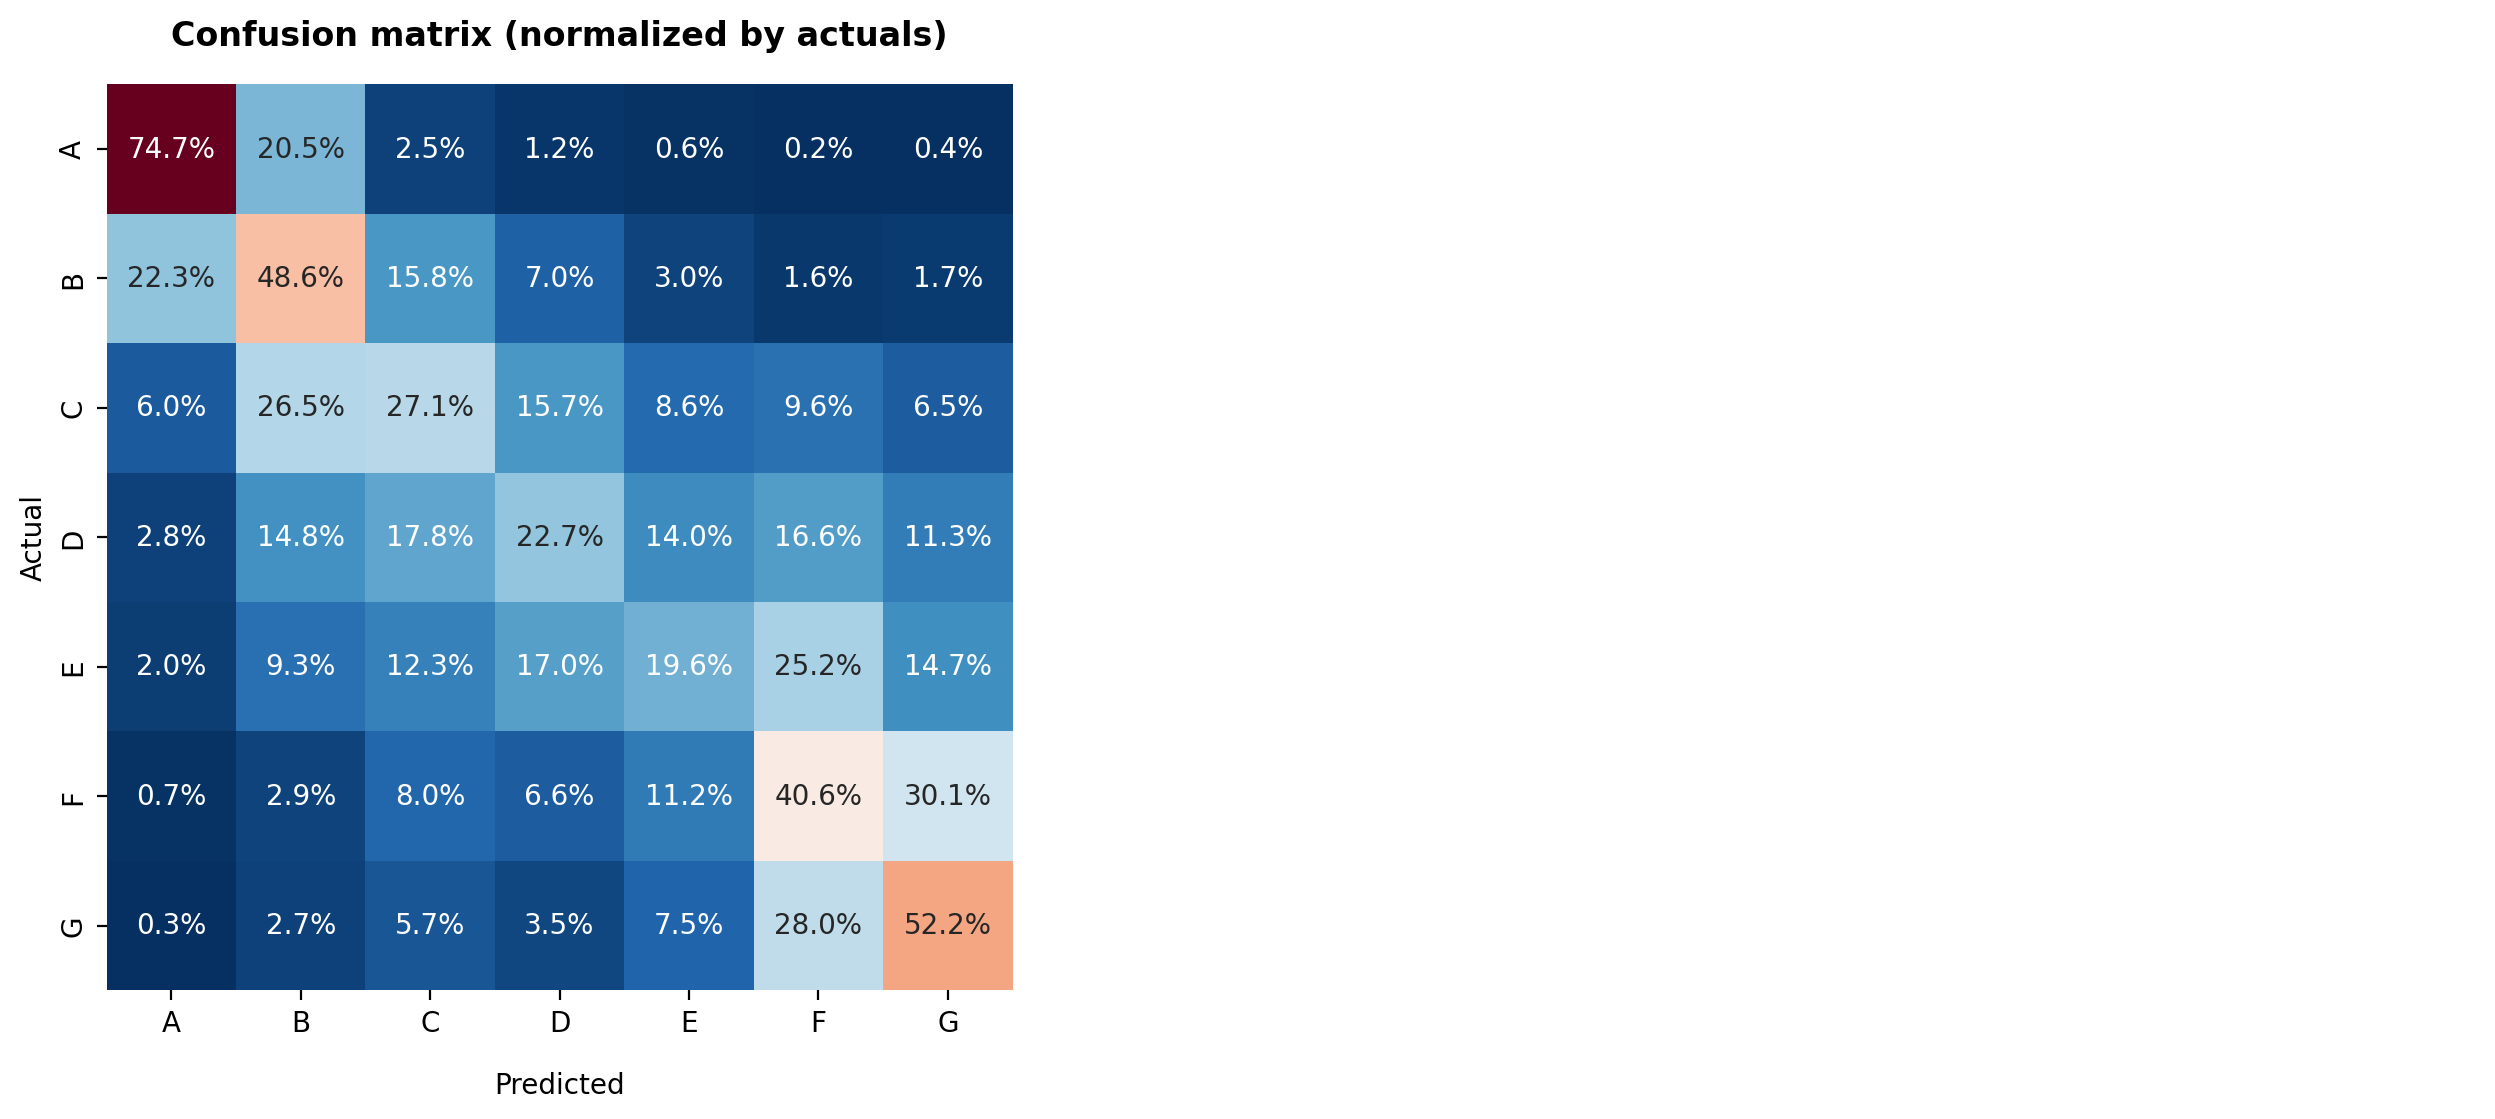

In [116]:
create_multi_cm(
    y_test_g,
    lgbm_pred_grade_max,
)

**Insights**

- Training LightGBM on the whole dataset for 2017-2018 improves prediction results very slightly. 
- The pattern remains the same - classes with more evident value dominance for top features are classified more accurately.

***

## Sub-grade prediction

**Approach**

- I chose macro F1-score as the main metric for classifier evaluation because all sub-grades are equally important.
- Loan sub-grade is predicted for each grade separately. For deeper model analysis, I chose all sub-grades for grade A as an example.

In [117]:
accepted_subgrade = accepted.drop(columns=["int_rate"])

### Feature selection

For feature selection I have combined two techniques: correlation and mutual information (mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other), by taking the list of 20 most correlated features and merging the list of 20 top features with the highest MI score.

In [118]:
top_sugrade_features = select_top_features(accepted_subgrade, "sub_grade")

In [119]:
additional_append_lst = ["annual_inc", "emp_length", "purpose", "sub_grade", ]
for col in additional_append_lst:
    if col not in top_sugrade_features:
        top_sugrade_features.append(col)

In [120]:
accepted_subgrade = accepted_subgrade[top_sugrade_features].copy()

In [121]:
accepted_subgrade.shape

(749786, 31)

### Pre-processing

In [122]:
numeric_features_s = list(accepted_subgrade.select_dtypes(include=["float64"]).columns)
numeric_features_s.extend(["cr_line_year", "issue_month", "cr_line_month"])
categorical_features_s = ["term", "verification_status", "purpose", "emp_length"]

In [123]:
feat_extractor_s = Pipeline(
    steps=[
        ("year", year),
        ("month", month),
    ]
)

In [124]:
categorical_transformer_s = Pipeline(
    steps=[("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))]
)

numeric_transformer_s = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

preprocessor_s = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer_s, categorical_features_s),
        ("numeric", numeric_transformer_s, numeric_features_s),
    ],
    remainder="passthrough",
)

In [125]:
pipe_transform_s = Pipeline(
    steps=[
        ("feat_extractor_s", feat_extractor_s),
        ("preprocessor_s", preprocessor_s),
    ]
)

### Sub-grade prediction by grade - LightGBM

In [126]:
subgrade_ml_eval = pd.DataFrame(columns=["Grade", "F1-score", "Precision", "Recall"])

for grade in ["A", "B", "C", "D", "E", "F", "G"]:

    print(f"Starting training for grade {grade}:")
    result = train_lgbm_subgrade(grade, accepted_subgrade, pipe_transform_s)
    print(f"Best F1-score on training set:", str(round(result[0], 3)))
    if grade == 'A':
        lgbm_hp = result[1]
    subgrade_ml_eval = pd.concat(
        [subgrade_ml_eval, pd.DataFrame(data=result[2], index=[str(grade) + '1 - ' + str(grade) + '5' ])]
    )

Starting training for grade A:


  0%|          | 0/5 [00:00<?, ?it/s]

Best F1-score on training set: 0.343
Starting training for grade B:


  0%|          | 0/5 [00:00<?, ?it/s]

Best F1-score on training set: 0.275
Starting training for grade C:


  0%|          | 0/5 [00:00<?, ?it/s]

Best F1-score on training set: 0.246
Starting training for grade D:


  0%|          | 0/5 [00:00<?, ?it/s]

Best F1-score on training set: 0.235
Starting training for grade E:


  0%|          | 0/5 [00:00<?, ?it/s]

Best F1-score on training set: 0.312
Starting training for grade F:


  0%|          | 0/5 [00:00<?, ?it/s]

Best F1-score on training set: 0.26
Starting training for grade G:


  0%|          | 0/5 [00:00<?, ?it/s]

Best F1-score on training set: 0.284


In [127]:
subgrade_ml_eval = subgrade_ml_eval.drop(columns=['Grade'])
subgrade_ml_eval.round(3)

F1-score  Precision  Recall
A1 - A5     0.342      0.351   0.353
B1 - B5     0.277      0.278   0.287
C1 - C5     0.241      0.246   0.255
D1 - D5     0.239      0.247   0.255
E1 - E5     0.303      0.308   0.323
F1 - F5     0.263      0.263   0.264
G1 - G5     0.298      0.303   0.300

**Insights**

- Quite low prediction results (F1-score varies between 0.23 to 0.34) indicate that features in this dataset are not suitable for loan sub-grade prediction and classifiers are having difficulties in distinguishing among different sub-grades. This was expected based on EDA findings - `sub-grade` has a very low correlation with other features besides `grade` and `int_rate`. 
- Sub-grade predictions for grade A was chosen as an example to explore classifier performance in more detail way and check feature importance. However need to mention that sub-grade predictions for other grades are less accurate and have lower values for evaluataion metrics.

#### Model evaluation - example for grade A

In [128]:
per_grade = accepted_subgrade[accepted_subgrade["grade"] == "A"]
y_s = per_grade["sub_grade"]
X_s = per_grade.drop(["sub_grade", "grade"], axis=1)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_s, y_s, test_size=0.20, stratify=y_s, random_state=RANDOM
)

In [129]:
lgbm_pipe_subgrade = Pipeline(
    steps=[
        ("preprocessor", pipe_transform_s),
        (
            "classifier",
            lgb.LGBMClassifier(
                objective="multiclass",
                class_weight="balanced",
                **lgbm_hp,
                verbosity=-1,
                random_state=RANDOM,)
        ),
    ]
).fit(X_train_s, y_train_s)

[LightGBM] [Warning] min_gain_to_split is set=3.069662196722378, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.069662196722378
[LightGBM] [Warning] lambda_l2 is set=84, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l1 is set=69, reg_alpha=0.0 will be ignored. Current value: lambda_l1=69


In [130]:
subgrade_pred = lgbm_pipe_subgrade.predict(X_test_s)

In [131]:
print(
    "\033[1m" + "Classification report for test set with LightGBM:\n\n" + "\033[0m",
    classification_report(
        y_test_s, subgrade_pred, target_names=["A1", "A2", "A3", "A4", "A5"]
    ),
)

Classification report for test set with LightGBM:

               precision    recall  f1-score   support

          A1       0.44      0.48      0.46      7178
          A2       0.26      0.37      0.31      5931
          A3       0.25      0.14      0.18      6402
          A4       0.41      0.18      0.25      7562
          A5       0.36      0.55      0.44      7514

    accuracy                           0.35     34587
   macro avg       0.34      0.34      0.33     34587
weighted avg       0.35      0.35      0.33     34587



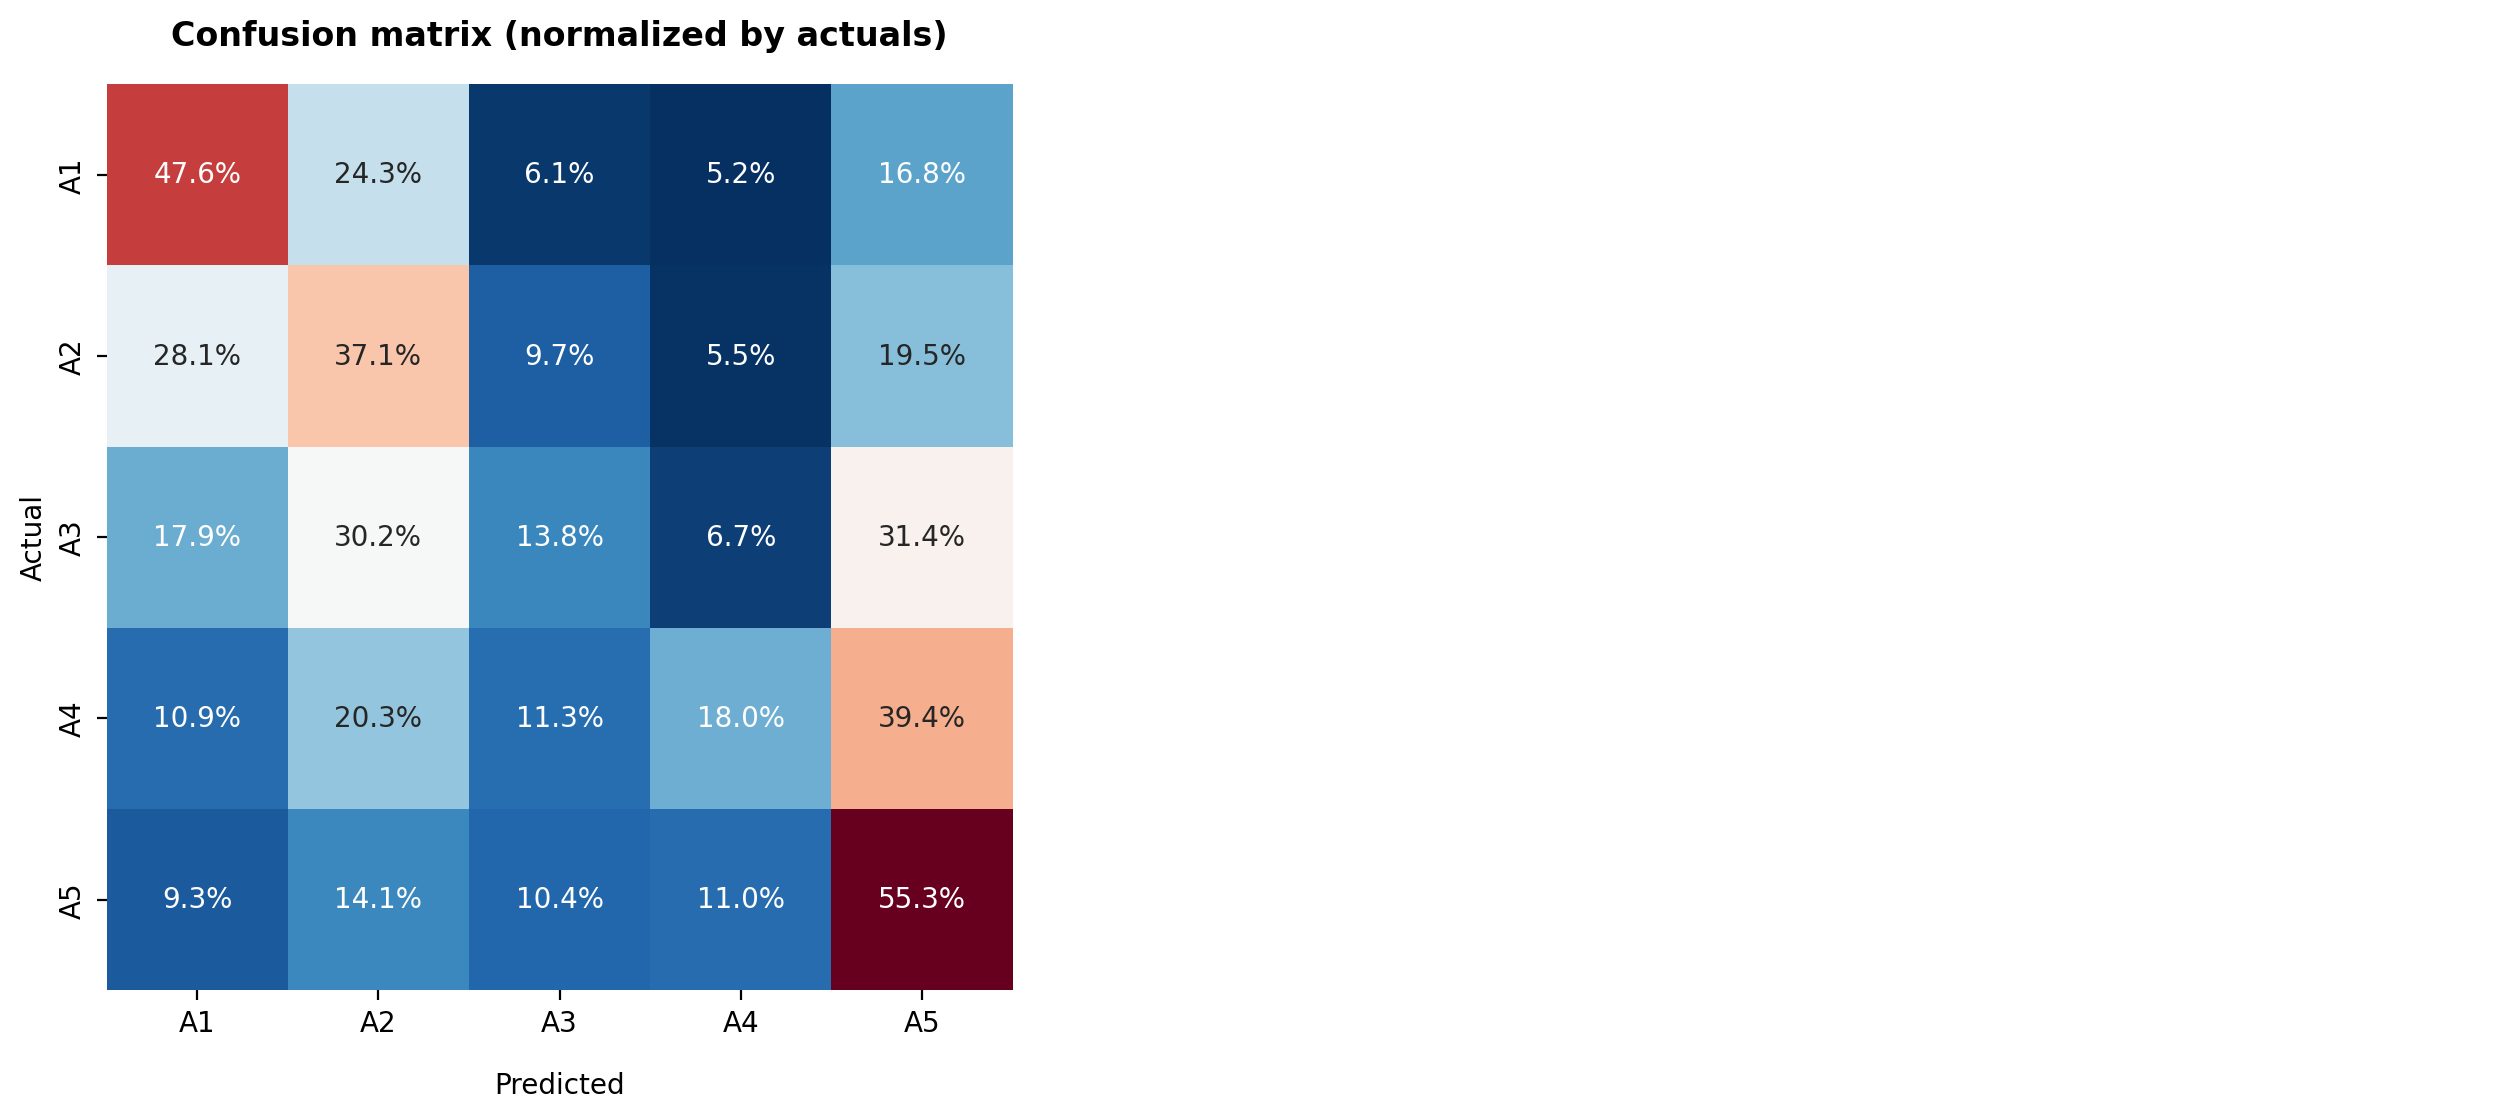

In [132]:
create_multi_cm(y_test_s, subgrade_pred, labels=["A1", "A2", "A3", "A4", "A5"])

**Insights**

- F1-score is the highest for sub-grades A1 and A5 (above 0.4) but low prediction results for other sub-grades drags down overall F1-score to ~0.3.

#### Feature importance -  example for grade A

In [133]:
feature_names_s = list(pipe_transform_s[1].transformers_[0][1].get_feature_names_out())
feature_names_s.extend(numeric_features_s)

In [134]:
X_test_s_tr = pipe_transform_s.transform(X_test_s)
explainer = shap.TreeExplainer(lgbm_pipe_subgrade[-1])
shap_values = explainer.shap_values(X_test_s_tr)

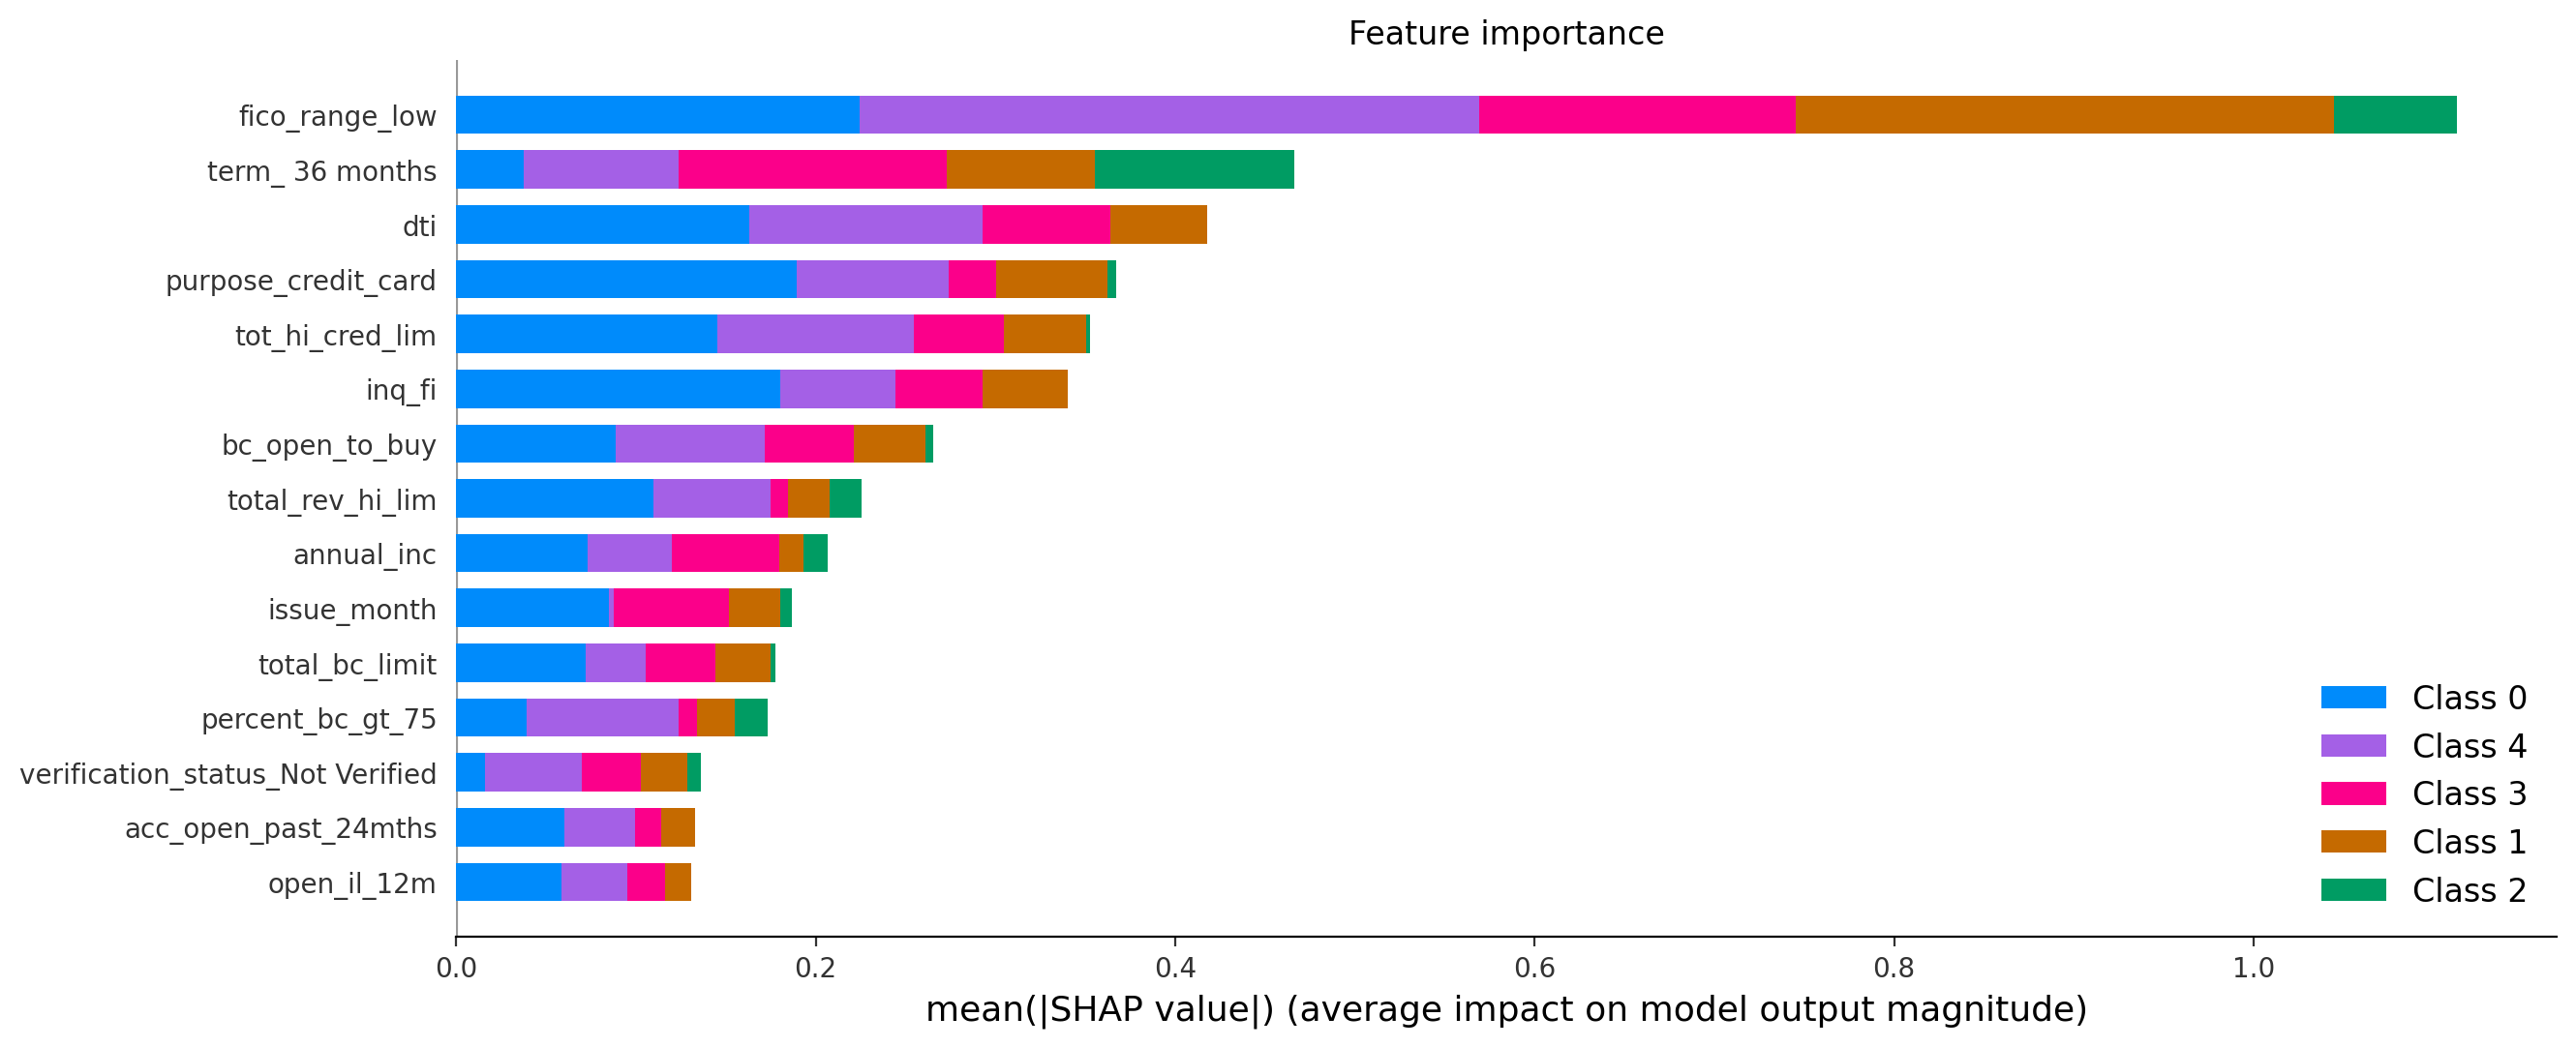

In [135]:
shap.summary_plot(
    shap_values,
    X_test_s_tr,
    feature_names=feature_names_s,
    max_display=15,
    show=False,
)

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches(14, 6)
ax.set_title("Feature importance", fontdict={"size": 12})
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=8)

**Insights**

- The top 4 most important features for grade prediction are:
    - `fico_range low`
    - `term_36 months`
    - `dti`
    - `purpose_credit_card`

***

## Interest rate

**Approach**

- I treat interest rate prediction as a regression problem and use two evaluation metrics:
    - R2 score - the proportion of the variance in the dependent variable that is predictable from the independent variable(s)
    - Root mean squared error (RMSE) - the standard deviation of the residuals (prediction errors)
- As sub-grade was predicted for each grade separately, it seemed sensible to predict interest rate the same way as they have the same data relationship with grade. However predicting interest rate by grade does not provide intended results (experiment could be found in Annex). Therefore I have decided to apply regressor for interest rate prediction regardless of grade.

In [136]:
accepted_int = accepted.drop(columns=["sub_grade"]).sample(frac=0.2).copy()

In [137]:
accepted_int.shape

(149957, 70)

### Feature selection

For feature selection I have combined two techniques: correlation and mutual information (mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other), by taking the list of 20 most correlated features and merging the list of 20 top features with the highest MI score.

In [138]:
top_int_rate_features = select_top_features(accepted_int, "int_rate")

In [139]:
additional_append_lst = [
    "annual_inc",
    "emp_length",
    "purpose",
    "earliest_cr_line",
    "issue_d",
    "int_rate",
    "grade",
]
for col in additional_append_lst:
    if col not in top_int_rate_features:
        top_int_rate_features.append(col)

In [140]:
accepted_int = accepted_int[top_int_rate_features].copy()

In [141]:
accepted_int.shape

(149957, 31)

### Pre-processing

In [142]:
y_rate = accepted_int["int_rate"]
X_rate = accepted_int.drop(["int_rate", "grade"], axis=1)
X_train_rate, X_test_rate, y_train_rate, y_test_rate = train_test_split(
    X_rate, y_rate, test_size=0.25, random_state=RANDOM
)

In [143]:
numeric_features_int = list(accepted_int.select_dtypes(include=["float64"]).columns)
numeric_features_int.remove("int_rate")
numeric_features_int.extend(["cr_line_year", "issue_month", "cr_line_month"])
categorical_features_int = ["term", "verification_status", "purpose", "emp_length"]

In [144]:
feat_extractor_int = Pipeline(
    steps=[
        ("year", year),
        ("month", month),
    ]
)

In [145]:
categorical_transformer_int = Pipeline(
    steps=[("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))]
)

numeric_transformer_int = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

preprocessor_int = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer_int, categorical_features_int),
        ("numeric", numeric_transformer_int, numeric_features_int),
    ],
    remainder="passthrough",
)

In [146]:
pipe_transform_int = Pipeline(
    steps=[
        ("feat_extractor_int", feat_extractor_int),
        ("preprocessor_int", preprocessor_int),
    ]
)

### Model selection

In [147]:
regressors_rate = [
    ("Dummy Regressor", DummyRegressor(strategy="median")),
    ("Ridge", Ridge()),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Random Forest", RandomForestRegressor()),
    (
        "XGBoost",
        xgb.XGBRegressor(
            objective="reg:squarederror",
        ),
    ),
    ("Light GBM", lgb.LGBMRegressor(objective="regression", verbose=-1)),
]

In [148]:
X_train_rate_tr = pipe_transform_int.fit_transform(X_train_rate)

In [176]:
rgss_comparison = compare_regressors(
    regressors_rate, X_train_rate_tr, y_train_rate
)
rgss_comparison = rgss_comparison.set_index('Regressor')
rgss_comparison.style.format("{0:,.3f}").background_gradient(cmap='Blues', subset=['R-squared'])

**Insights**

- R-squared indicates that in most cases about 50% of the target variation could be explained by independent variables.
- The highest R-squared and the lowest RMSE is provided by LightGBM and it was chosen for HP tuning.

### LightGBM

In [151]:
sampler = TPESampler(seed=RANDOM)
study_rate_lgbm = optuna.create_study(direction="minimize", sampler=sampler)
study_rate_lgbm.optimize(
    lambda trial: objective_lgbm_int_rate(trial, X_train_rate_tr, y_train_rate),
    n_trials=10,
    show_progress_bar=True,
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [152]:
lgbm_reg_hp = study_rate_lgbm.best_params

lgbm_pipe_rate = Pipeline(
    steps=[("preprocessor", pipe_transform_int),
        (
            "regressor",
            lgb.LGBMRegressor(
                objective="regression",
                verbosity=-1,
                **lgbm_reg_hp,
                random_state=RANDOM,
            )
        ),
    ]
).fit(X_train_rate, y_train_rate)

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] lambda_l1 is set=69, reg_alpha=0.0 will be ignored. Current value: lambda_l1=69


#### Training results

In [153]:
lgbm_rate_pred_train = lgbm_pipe_rate.predict(X_train_rate)

In [154]:
print(
    f"R-squared score for train set: {lgbm_pipe_rate.score(X_train_rate, y_train_rate):.3f}"
)
print(
    f"RMSE for train set: {np.sqrt(mean_squared_error(y_train_rate, lgbm_rate_pred_train)):.3f}"
)

R-squared score for train set: 0.654
RMSE for train set: 3.062


#### Model evaluation

In [155]:
lgbm_pred_rate = lgbm_pipe_rate.predict(X_test_rate)

In [156]:
print(
    f"R-squared score for test set: {lgbm_pipe_rate.score(X_test_rate, y_test_rate):.3f}"
)
print(
    f"RMSE for test set: {np.sqrt(mean_squared_error(y_test_rate, lgbm_pred_rate)):.3f}"
)

R-squared score for test set: 0.503
RMSE for test set: 3.684


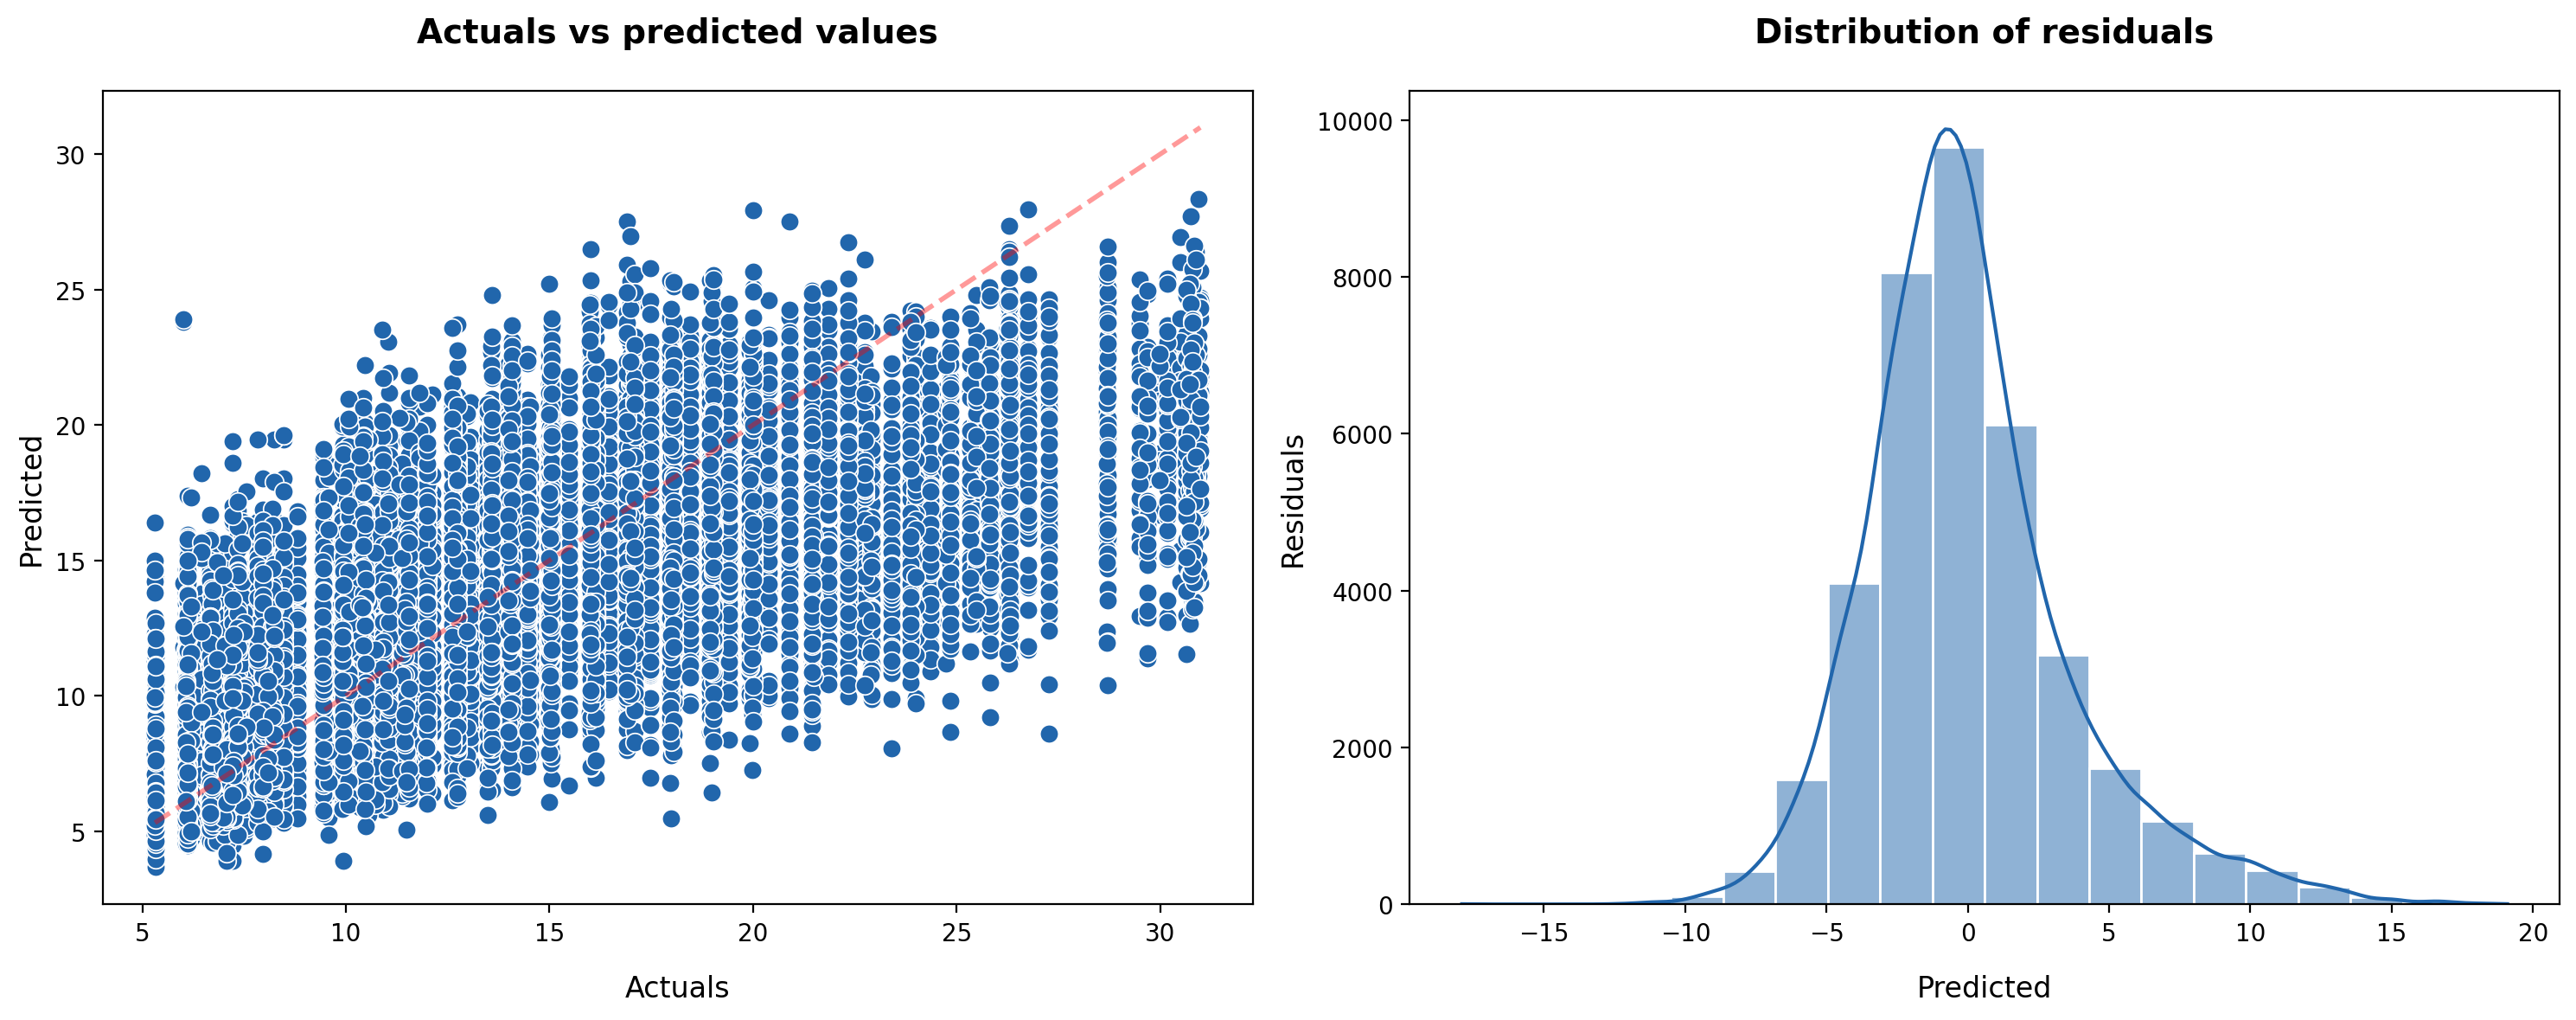

In [157]:
evaluate_model(y_test_rate, lgbm_pred_rate)

In [158]:
# joblib.dump(lgbm_pipe_rate, "models/int_rate_regressor.pkl")

**Insights**

- After HP tuning R-squared for test set remains ~0.5 which indicates medium regressor skill to predict interest rate based on existing features.
- Comparing actuals vs predicted, expectation is that all points would be close to diagonal line (predicted close to actual value), but in this case the band around diagonal line is very wide and high interest rate values is very rarely predicted correctly. This might be because of low number of observations for high interest rate (the highest risk loans).
- The range of residuals is very wide which supports incorrect predictions at higher (and lower) end of interest rate distribution.
- It difficult to evaluate RMSE, because the range of interest rate is wide: 3.6 seems to be a fair error for high interest rate values but this kind of error is half of small interest rate.

#### Feature importance

In [159]:
feature_names_int = list(
    pipe_transform_int[1].transformers_[0][1].get_feature_names_out()
)
feature_names_int.extend(numeric_features_int)

In [160]:
X_test_int_tr = pipe_transform_int.transform(X_test_rate)
explainer = shap.TreeExplainer(lgbm_pipe_rate[-1])
shap_values = explainer.shap_values(X_test_int_tr)

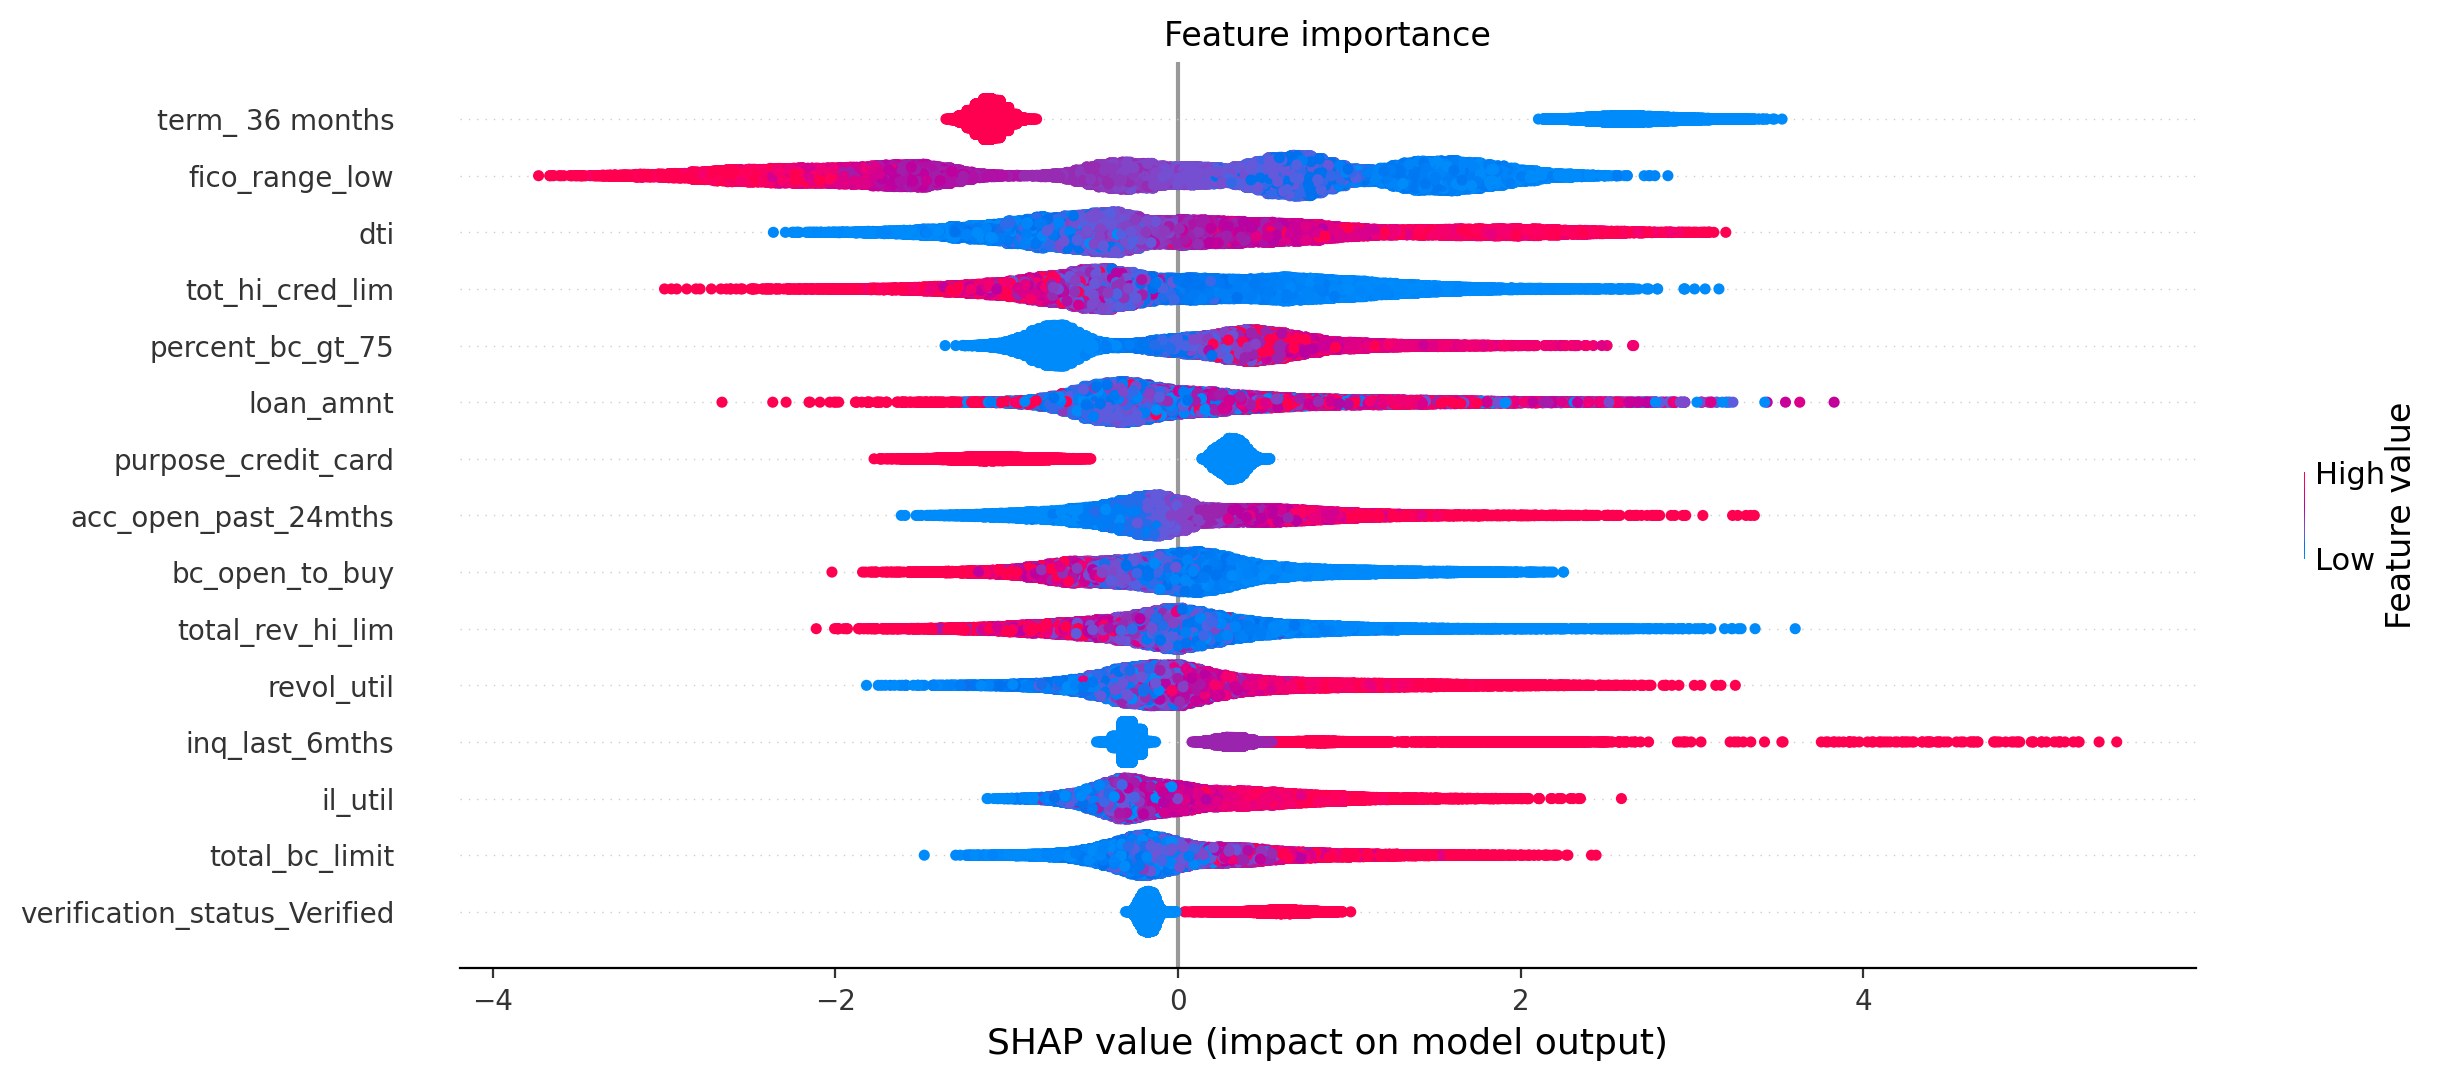

In [161]:
shap.summary_plot(
    shap_values,
    X_test_int_tr,
    feature_names=feature_names_int,
    max_display=15,
    show=False,
)

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches(14, 6)
ax.set_title("Feature importance", fontdict={"size": 12})
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=8)

**Insights**

- As expected, the top 3 most important features for interest rate are very similar to feature importance for grade and sub-grade predictions:
    - `term_36 months`,
    - `fico_range low`
    - `dti`


## ML Summary

In this notebook, I provided a quite extensive and detailed analysis of ML results in order to choose the best performing algorithm for each target. To summarize what was discovered:

- Classifying loans into accepted or rejected:
    - After HP tuning, XGBoost provides the highest F1-score (\~0.97) and shows a high skill to distinguish between classes. Percentage of true negatives (whether application is going to be rejected ) is a bit higher (\~99) than true positives (\~94%) which is expected due to imbalanced dataset.
    - Testing model performance on unseen 2018 data shows a slight decrease in F1-score due to the decrease in recall of class 1. It might be useful to try out different thresholds to level precision and recall for class 1.
    - In general the great model performance indicates that features in this dataset are sufficient to make future predictions.
    - Feature importance by XGBoost supports EDA findings. The most important features for classifying loan into accepted or rejected are the following:
        - `fico_score`
        - `dti_ratio`
        - `emp_length_<1 year`
        - `amount_requested`
- Predicting loan grade: 
    - In general, grade prediction results are quite low regardless of the classifier used. 
    - LightGBM provides the highest F1-score which is ~0.3 idicating that model is having difficulties distinguishing between close classes (grades). 
    - The general trend is that feature importance corresponds with EDA findings. The most important features for grade prediction are the following:
        - `term_36 months`
        - `fico_range low`
        - `dti`
        - `loan_amnt`
    - Classes with more evident value dominance for top features are classified more accurately.
- Predicting loan sub-grade and interest loan:     
    - I was looking for the consistent and logical way to predict sub-grade and interest rate as they are features derived from grade feature and more importantly are closely interconnected as per analysis results: sub-grade is basically categorical representation of interest rate. However algorithm results dictated the structure of ML for these two targets.
    - Loan sub-grade is predicted for each grade separately as this way provides the most accurate predictions. However F1-score varies between 0.23 to 0.34 indicating that features in this dataset are not sufficient or suitable for loan sub-grade prediction and classifiers are having difficulties in distinguishing among different sub-grades.
    - Surprisingly, predicting interest rate regardless of grade provides much better results than predicting interest rate for each grade separately. The highest R-squared score is provided by LightGBM - ~0.5 indicating medium regressor skill to predict interest rate based on existing features.
- I have saved and deployed models for all 4 targets as per project requirements. However I think that this dataset need to be expanded or advanced feature engineering done to improve predictions for loan grade, sub-grade and interest rate.

### Improvements

- More accurate train/test split by time (out-of-time sampling)
- Applying dimensionality reduction algorithms
- Performing more extensive feature engineering
- Building ensembles of machine learning models

## Annex

### Interest rate stats by sub-grade

In [162]:
accepted.groupby('sub_grade').agg(mean_int_rate=('int_rate', 'mean'), count_int_rate=('int_rate', 'count')).round(2)

mean_int_rate  count_int_rate
sub_grade                               
A1                  5.65           35891
A2                  6.60           29652
A3                  7.06           32010
A4                  7.60           37810
A5                  8.17           37569
B1                  9.42           43710
B2                 10.17           42987
B3                 10.73           38854
B4                 11.22           43376
B5                 12.09           47656
C1                 12.89           48031
C2                 13.81           41301
C3                 14.32           42866
C4                 15.30           41930
C5                 16.23           42914
D1                 17.39           24002
D2                 18.37           23053
D3                 19.33           22452
D4                 20.34           16618
D5                 21.79           14726
E1                 23.02            5882
E2                 24.01            6087
E3                 24.95            5894
E4                 25.85            5422
E5                 26.63            7823
F1                 28.69            2765
F2                 29.60            1364
F3                 30.12            1372
F4                 30.59            1085
F5                 30.73            1161
G1                 30.79            1227
G2                 30.84             555
G3                 30.89             532
G4                 30.94             600
G5                 30.99             609

### Interest rate prediction by grade - LightGBM

In [163]:
rate_ml_eval = pd.DataFrame(columns=["Grade", "R2-score", "RMSE"])

for grade in ["A", "B", "C", "D", "E", "F", "G"]:

    print(f"Starting training for grade {grade}:")
    result = train_lgbm_int_rate(grade, accepted_int, pipe_transform_int)
    print(f"Highest R2 score on training set:", str(round(result[0], 3)))
    rate_ml_eval = pd.concat(
        [rate_ml_eval, pd.DataFrame(data=result[2], index=['Int. rates for grade ' + str(grade)])]
    )
    
    if grade == 'A': 
        lgbm_hp_rate = result[1]

Starting training for grade A:


  0%|          | 0/10 [00:00<?, ?it/s]

Highest R2 score on training set: 0.818
Starting training for grade B:


  0%|          | 0/10 [00:00<?, ?it/s]

Highest R2 score on training set: 0.964
Starting training for grade C:


  0%|          | 0/10 [00:00<?, ?it/s]

Highest R2 score on training set: 1.193
Starting training for grade D:


  0%|          | 0/10 [00:00<?, ?it/s]

Highest R2 score on training set: 1.507
Starting training for grade E:


  0%|          | 0/10 [00:00<?, ?it/s]

Highest R2 score on training set: 1.372
Starting training for grade F:


  0%|          | 0/10 [00:00<?, ?it/s]

Highest R2 score on training set: 0.797
Starting training for grade G:


  0%|          | 0/10 [00:00<?, ?it/s]

Highest R2 score on training set: 0.071


In [164]:
rate_ml_eval = rate_ml_eval.drop(columns='Grade')

rate_ml_eval.round(3)

R2-score   RMSE
Int. rates for grade A     0.267  0.816
Int. rates for grade B     0.100  0.965
Int. rates for grade C     0.075  1.216
Int. rates for grade D     0.044  1.487
Int. rates for grade E     0.123  1.376
Int. rates for grade F    -0.007  0.857
Int. rates for grade G     0.034  0.077

#### Model evaluation - example for grade A

In [165]:
per_grade = accepted_int[accepted_int["grade"] == "A"]
y_rate = per_grade["int_rate"]
X_rate = per_grade.drop(["int_rate", "grade"], axis=1)
X_train_rate, X_test_rate, y_train_rate, y_test_rate = train_test_split(
    X_rate, y_rate, test_size=0.20, random_state=RANDOM
)

In [166]:
lgbm_pipe_rate = Pipeline(
    steps=[
        ("preprocessor", pipe_transform_int),
        (
            "classifier",
            lgb.LGBMRegressor(objective="regression", verbosity=-1, **lgbm_hp_rate),
        ),
    ]
).fit(X_train_rate, y_train_rate)

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] lambda_l1 is set=69, reg_alpha=0.0 will be ignored. Current value: lambda_l1=69


In [167]:
rate_pred = lgbm_pipe_rate.predict(X_test_rate)

In [168]:
print(
    f"LightGBM R-squared score for test set: {lgbm_pipe_rate.score(X_test_rate, y_test_rate):.3f}"
)
print(
    f"LightGBM RMSE for test set: {np.sqrt(mean_squared_error(y_test_rate, rate_pred)):.3f}"
)

LightGBM R-squared score for test set: 0.267
LightGBM RMSE for test set: 0.816


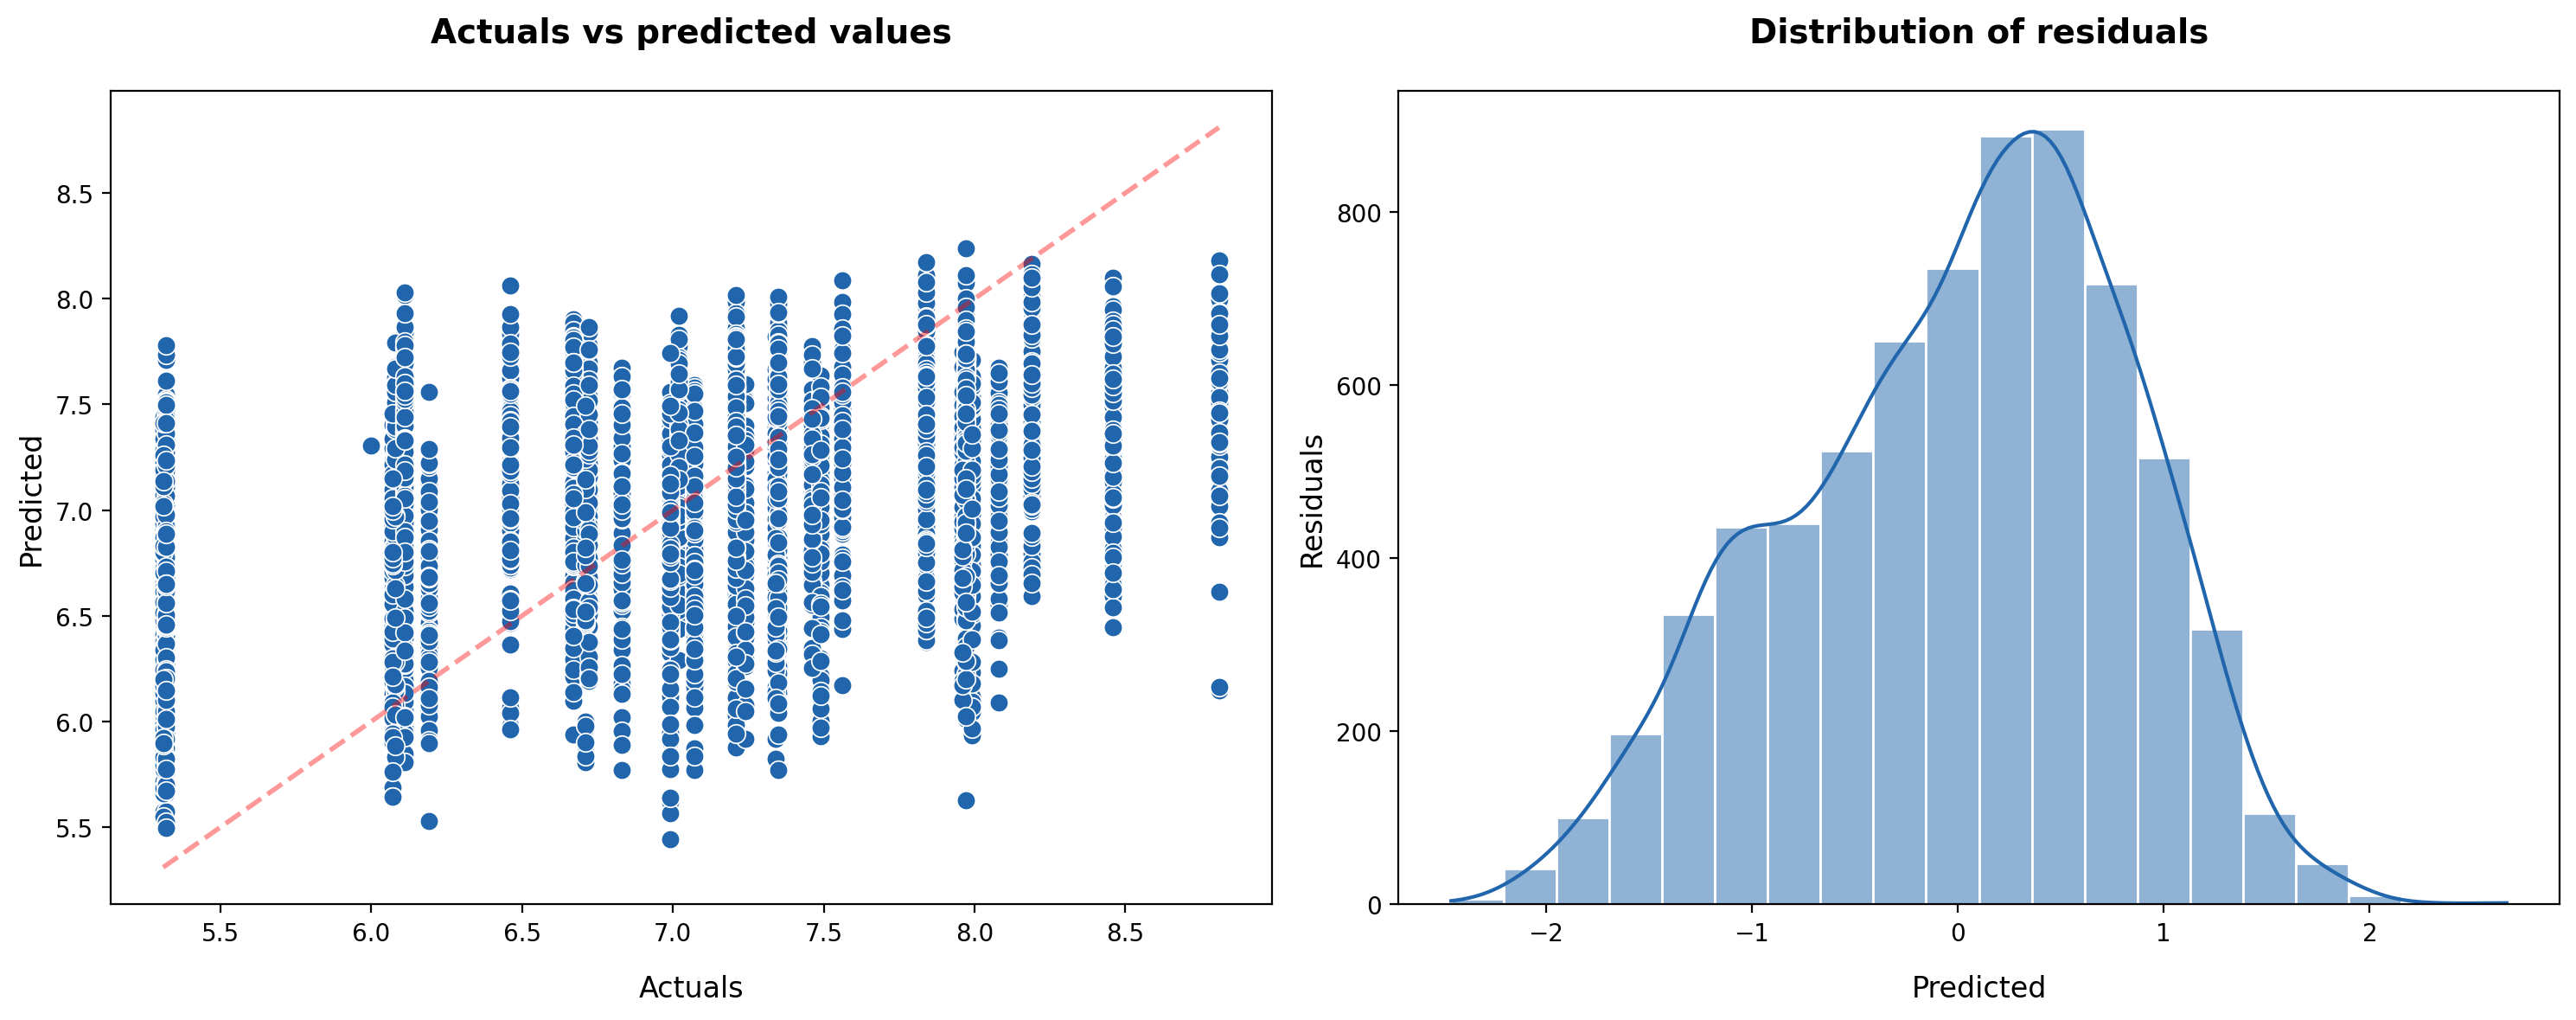

In [169]:
evaluate_model(y_test_rate, rate_pred)

#### Feature importance

In [170]:
feature_names_int = list(
    pipe_transform_int[1].transformers_[0][1].get_feature_names_out()
)
feature_names_int.extend(numeric_features_int)

In [171]:
X_test_int_tr = pipe_transform_int.transform(X_test_rate)
explainer = shap.TreeExplainer(lgbm_pipe_rate[-1])
shap_values = explainer.shap_values(X_test_int_tr)

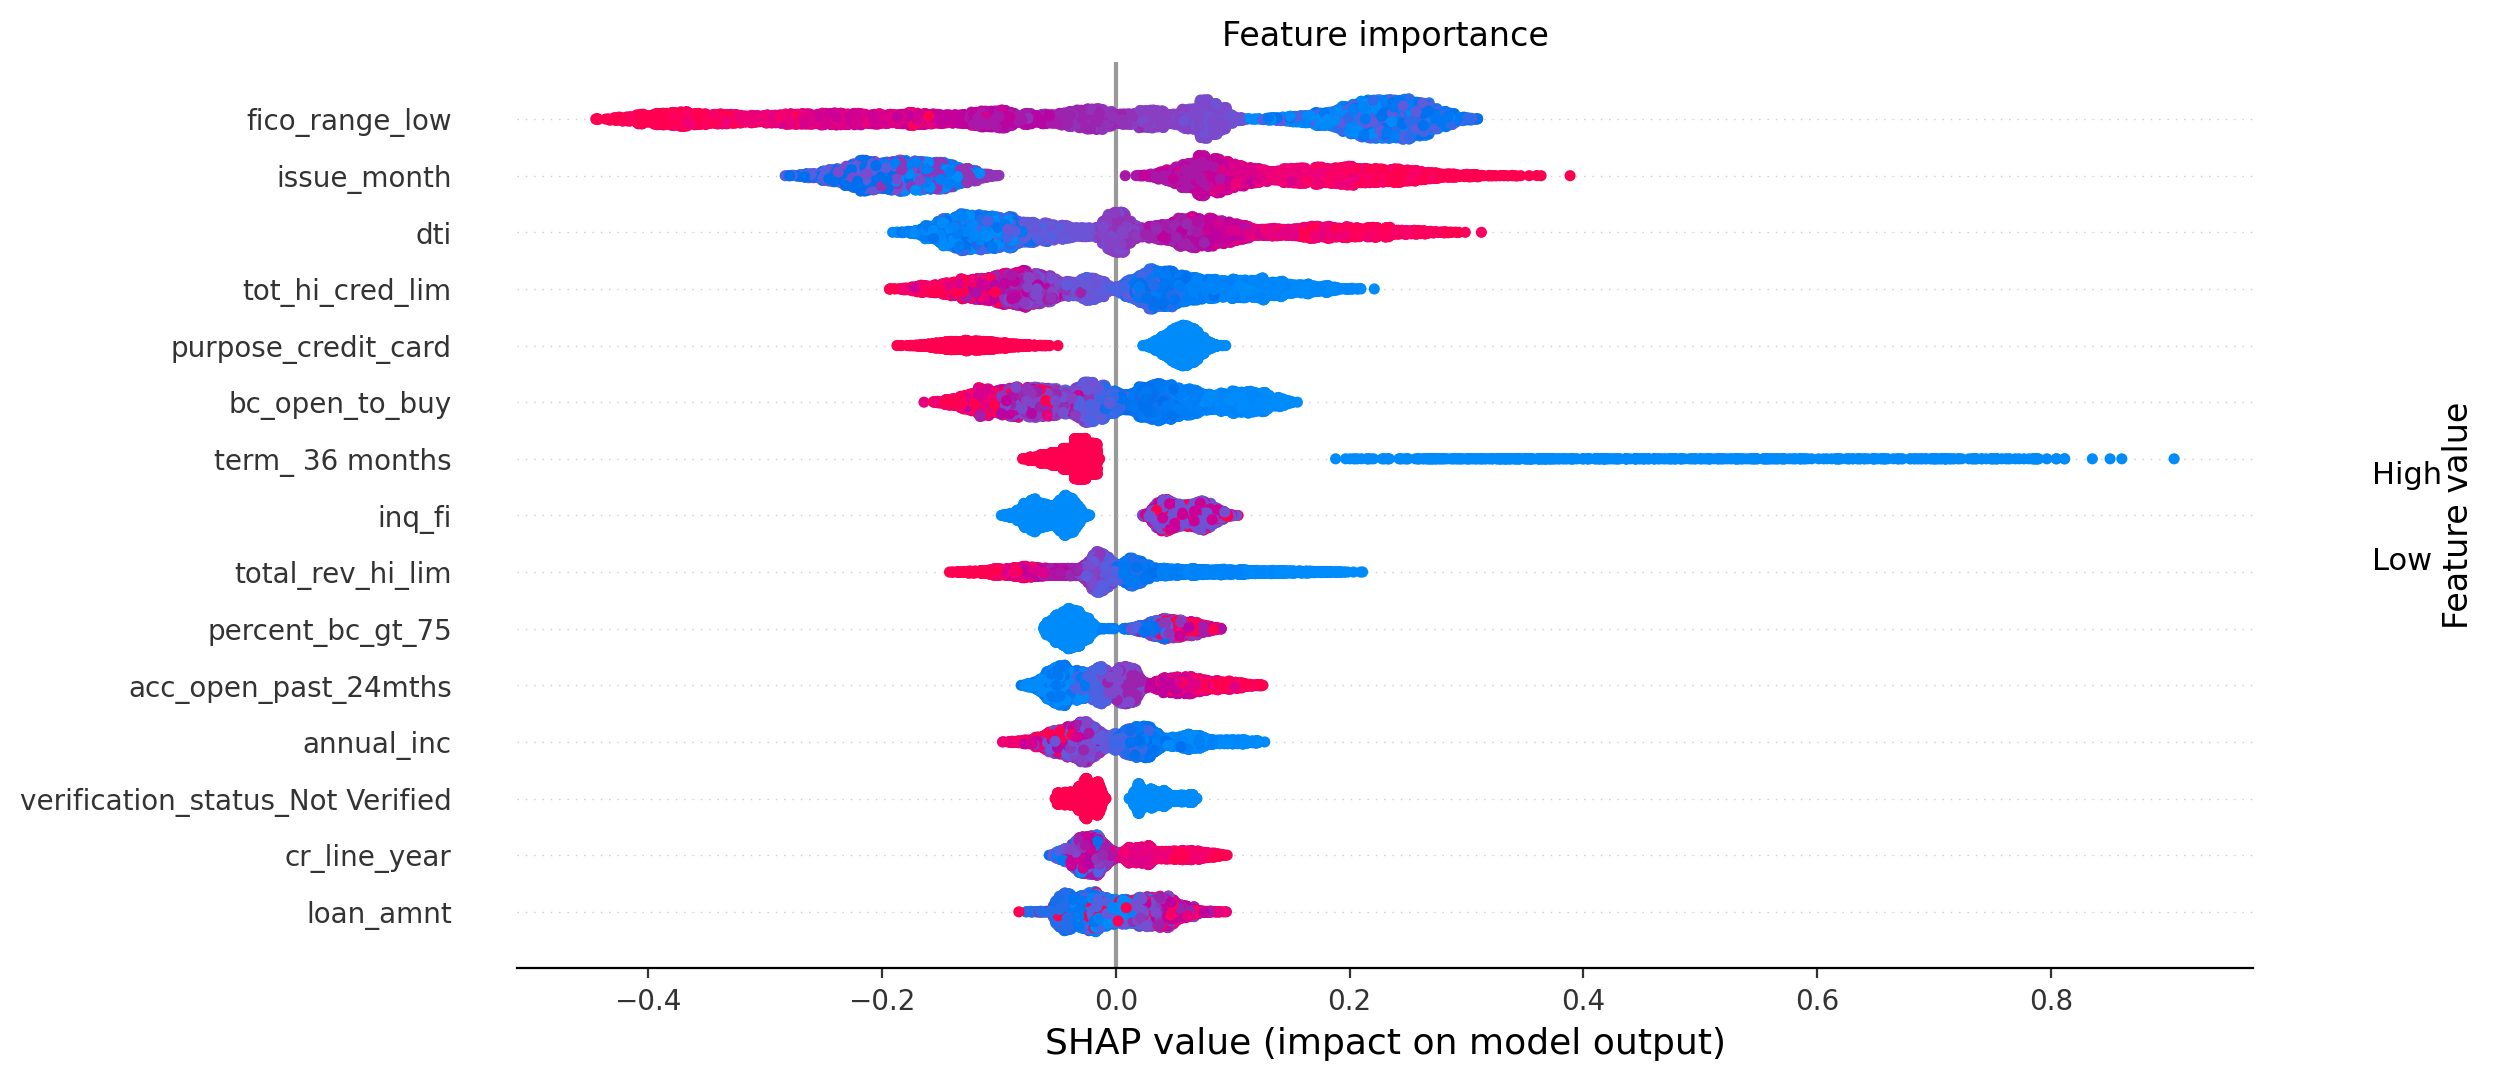

In [172]:
shap.summary_plot(
    shap_values,
    X_test_int_tr,
    feature_names=feature_names_int,
    max_display=15,
    show=False,
)

fig, ax = plt.gcf(), plt.gca()

fig.set_size_inches(14, 6)
ax.set_title("Feature importance", fontdict={"size": 12})
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=8)